# **Avance 2. Series de tiempo univariadas:**
# **Caso volumen de acopio nacional de leche cruda** 🐮
## **Universidad Nacional de Colombia.**
## **Docente:**

  - [Sergio Alejandro Calderón Villanueva](sacalderonv@unal.edu.co)

## **Autores:**

  - [Michel Mendivenson Barragán Zabala](mbarraganz@unal.edu.co)
  - [Sharon Juliana Zambrano Ortiz](shzambranoo@unal.edu.co)
  - [Julieth Karina Vegar Barajas](jvejar@unal.edu.co)

---
**Nota 1:** Este cuaderno contiene código de R y python cuyos objetos interáctuan entre sí (Veáse: [R and Python in one Jupyter notebook](https://stackoverflow.com/questions/39008069/r-and-python-in-one-jupyter-notebook))

**Nota 2:** Si se está editando este documento desde Google Collab, no es posible hacer `commit` directamente al repositorio. En cambio, hay que dar en la opción `File > Save a copy in GitHub`.

**Nota 3:** Por simplicidad, las series se separaron en dos cuadernos. En este se encuentran todos los procedimientos relacionados a la serie de [Volumen de acopio de leche mensual en el país](https://uspleche.minagricultura.gov.co/documentos.html) con corte a Diciembre de 2023.

---

### **Paquetes utilizados**

In [ ]:
# Este módulo es usado para correr código de R y hacer que los objetos de R interactuén con python
%load_ext rpy2.ipython

# Manejo de datos en general
import pandas as pd
import numpy as np

# Para poder graficar
import matplotlib.pyplot as plot

# Construcción del árbol de decisión
from sklearn.tree import DecisionTreeRegressor

# Tuning del árbol
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Medidas de precisión
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Para el ajuste de hiperparámetros
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Para mostrar la estructura del árbol
from sklearn.tree import plot_tree

# Escalado de los datos:
from sklearn.preprocessing import MinMaxScaler


# Para que no aparezcan alertas
import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# 🐮 **Lectura de los datos**

here() starts at /home/mendivenson/Notarium/4) Classwork/2024-I. Series de tiempo univariadas


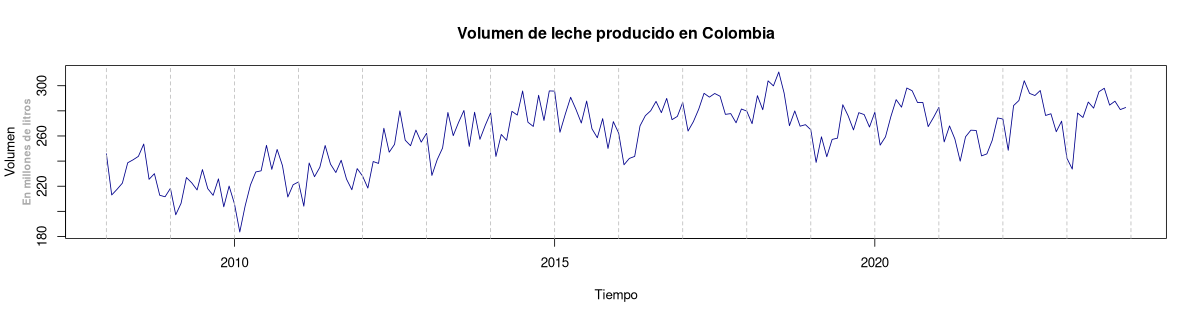

In [ ]:
    %%R -w 15 -h 4 --units in -r 80
Ruta = '/home/mendivenson/Documents/4) Series de Tiempo Univariadas (SdTU)/2) Espacio de trabajo/' # Cambie esta ruta a la que corresponda
source(paste0(Ruta,'Script análisis/Leche: Lectura de datos.R'))
abline(v = 2008:2024, col = 'gray', lty = 'dashed')

---

# 🐮 **Análisis descriptivo**

En el avance 1, se realizaron los respectivos análisis de homocedasticidad, tendencia y estacionalidad para cada una de las series obteniendo los siguientes resultados:

## 🐮🐮 **Estabilización de la varianza**

Al buscar un $\lambda$ para la transformación Box Cox encontramos que el que maximiza la log verosimilitud es $3.15$  apróximadamente por lo que se aplica la transformación obteniendo lo siguiente:

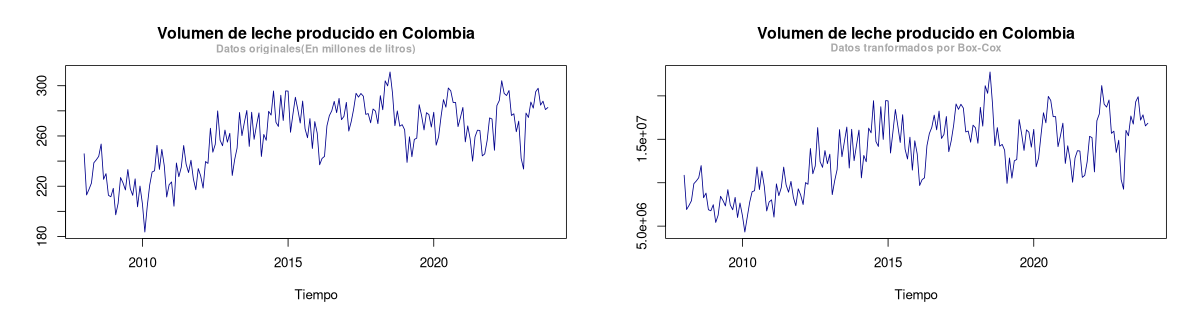

In [ ]:
%%R -w 15 -h 4 --units in -r 80
source(paste0(Ruta,'Script análisis/Leche: Análisis de varianza.R'))

Como la serie no cambia realmente de estructura sino que aumenta de forma drástica su escala, se decide no aplicar la transformación Box Cox.

## 🐮🐮 **Eliminación de tendencia**

La serie claramente presenta cierta tendencia no completamente lineal por lo que se decide aplicar suavizamiento kernel:

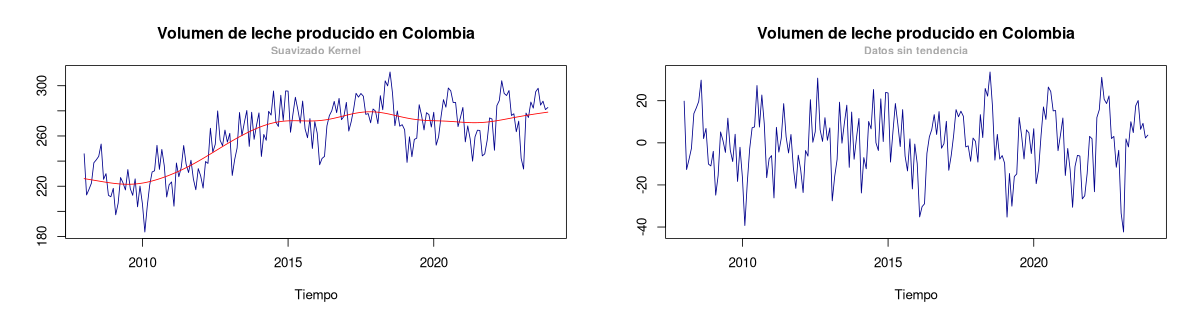

In [ ]:
%%R -w 15 -h 4 --units in -r 80 -o  leche
# -o leche pasa el objeto leche a python como un array: Este objeto se utilizará en los árboles de decisión
# pues estos on útiles para datos sin tendencia
source(paste0(Ruta,'Script análisis/Leche: Eliminación de la tendencia.R'))

## 🐮🐮 **Análisis de estacionalidad**

En este caso, se utiizaron distintas herramientas gráficas para determinar la estacionalidad de la serie. Sin embargo, aquí presentamos únicamente el periodograma, las subseries y el gráfico de retardos:

### 🐮🐮🐮 **Gráfico de retardos**

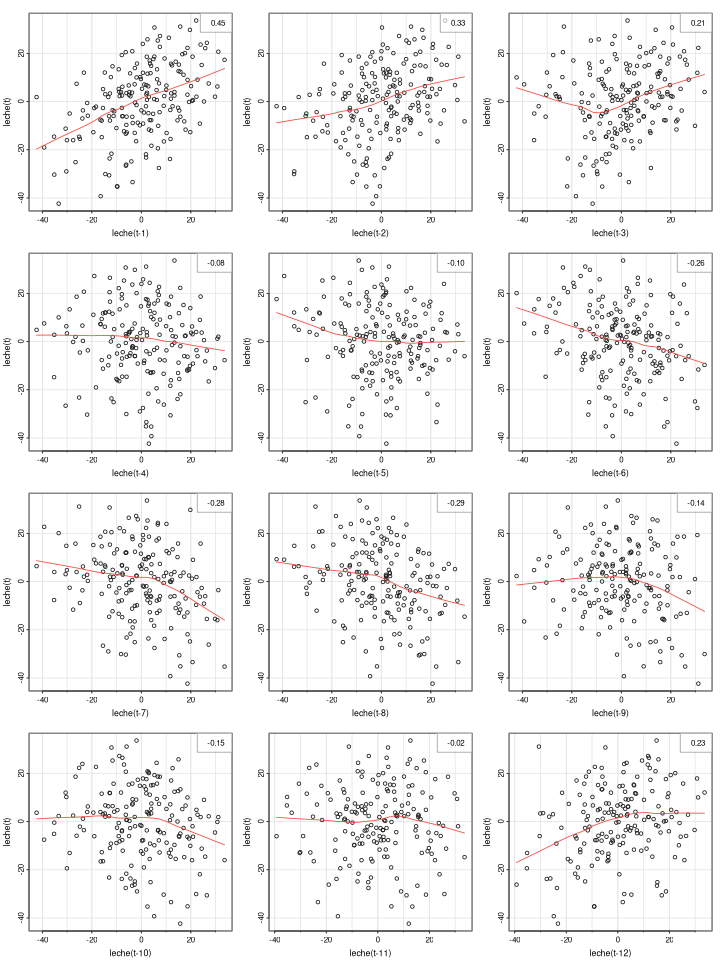

In [ ]:
%%R -w 9 -h 12 --units in -r 80
astsa::lag1.plot(leche,12,corr = T, )

### 🐮🐮🐮 **Subseries mensuales**

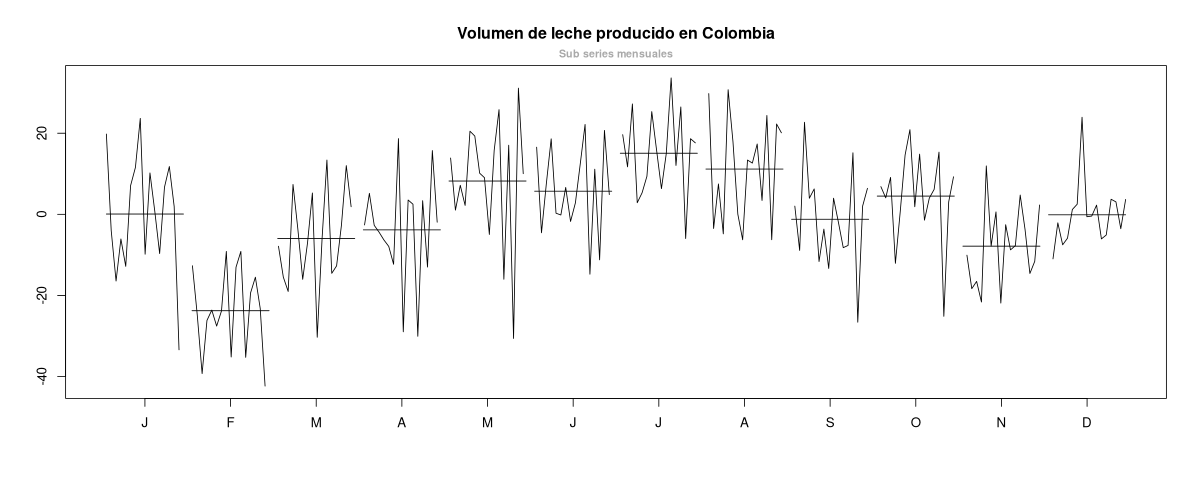

In [ ]:
%%R -w 15 -h 6 --units in -r 80
monthplot(leche, ylab = '', main = 'Volumen de leche producido en Colombia')
mtext(bquote(bold('Sub series mensuales')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')

### 🐮🐮🐮 **Periodograma**

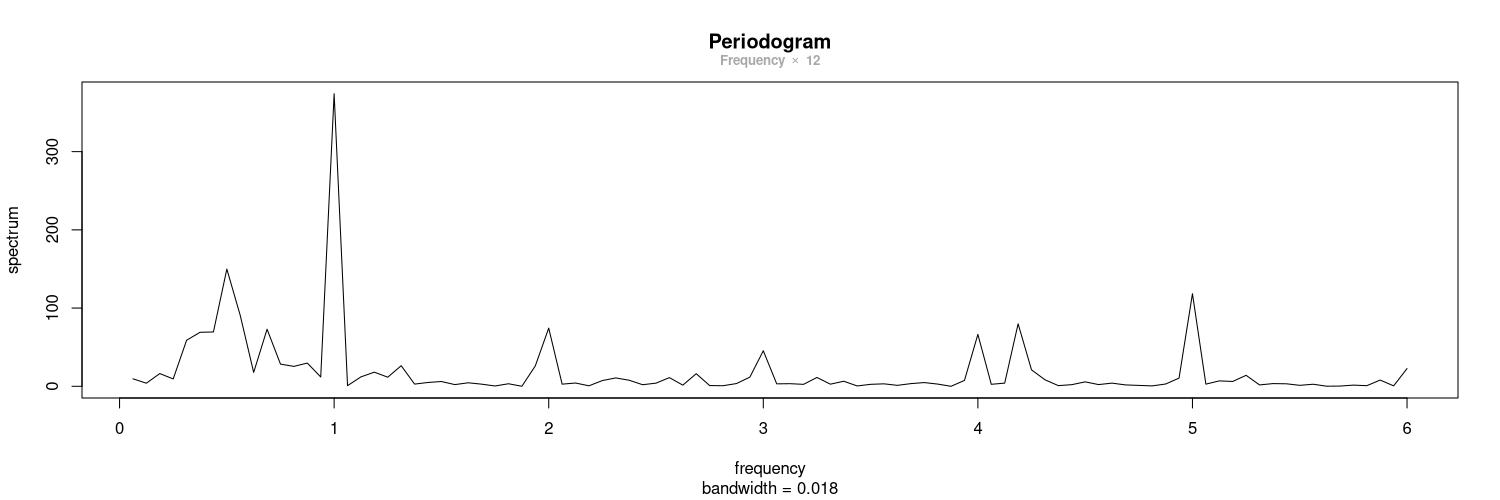

In [ ]:
%%R -w 15 -h 5 --units in -r 100
SpectrumLeche = spectrum(leche, log = 'no', main = 'Periodogram')
mtext(latex2exp::TeX('Frequency $\\times$ 12', bold = T),
      side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

Luego de probar distintos métodos, se decide utilizar variables dummys para intentar ajustar la estacionalidad de la serie. Los resultados se encuentran a continuación:

El valor máximo no. 1  en el que se máximiza el periodograma es 374.0577 
en la frecuencia  1 
El valor máximo no. 2  en el que se máximiza el periodograma es 149.8748 
en la frecuencia  0.5 
El valor máximo no. 3  en el que se máximiza el periodograma es 118.3689 
en la frecuencia  5 


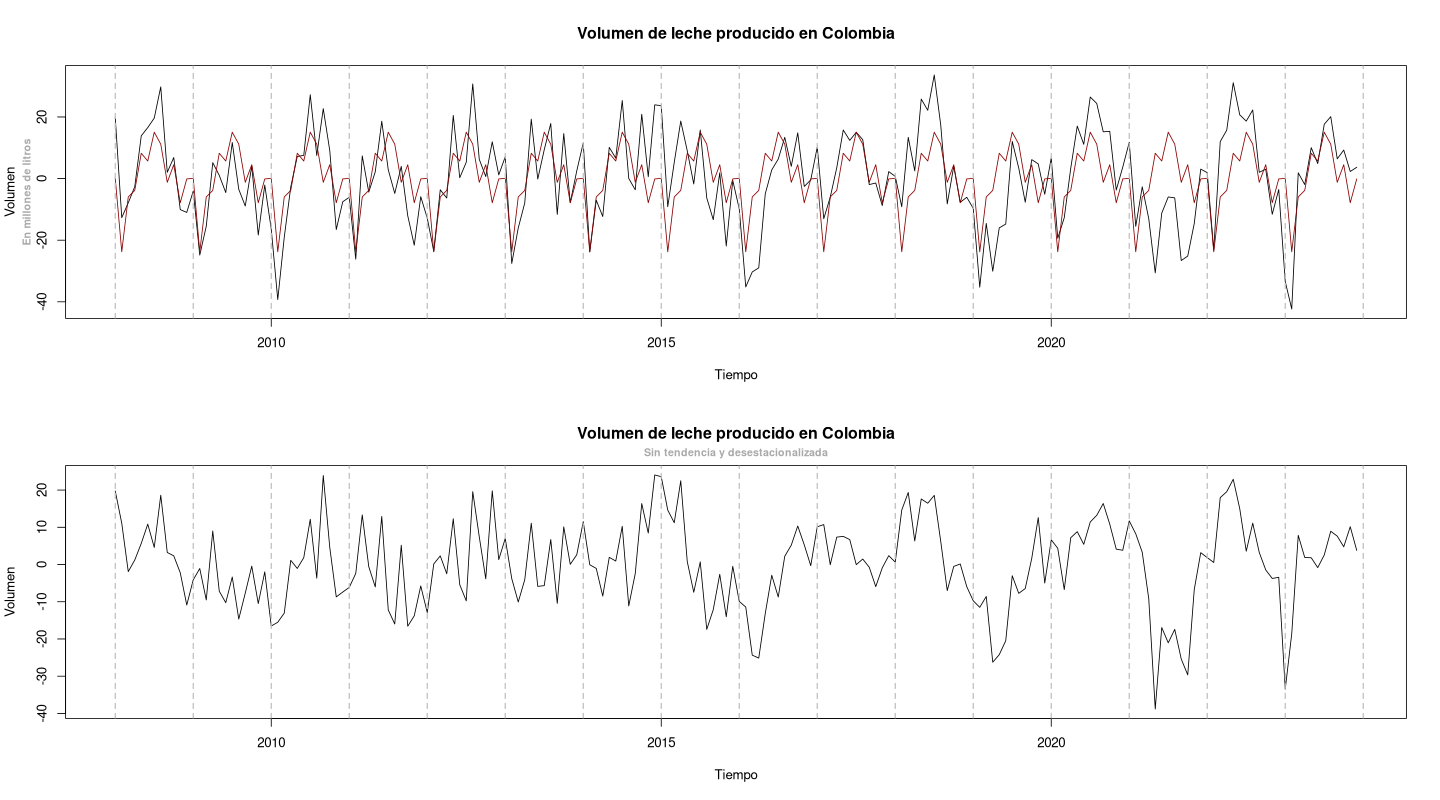

In [ ]:
%%R -w 18 -h 10 --units in -r 80
source(paste0(Ruta, 'Script análisis/Leche: Estacionalidad.R'))

---

# 🐮 **Árboles de decisión**

Para los árboles de decisión, tendremos en cuenta lo encontrado en la sección anterior:

- Utilizaremos los datos sin tendencia ajustados antes con regresión Kernel.
- Como la serie cuenta con apenas 192 datos utilizaremos validación cruzada para ajustar hiperparámetros.
    -  Dejaremos 180 datos de entrenamiento y 12 datos de prueba.
Antes de iniciar con cualquier código de python debemos cambiar el tipo de dato de `leche` de `array` a `pd.Series`

In [ ]:
type(leche)

numpy.ndarray

In [ ]:
date_index = pd.date_range(start = '2008-01', periods = len(leche), freq = 'M')
leche = pd.Series(leche, index = date_index)
leche

2008-01-31    19.795864
2008-02-29   -12.682066
2008-03-31    -7.872412
2008-04-30    -2.623688
2008-05-31    13.881874
                ...    
2023-08-31    20.100389
2023-09-30     6.408911
2023-10-31     9.259564
2023-11-30     2.303314
2023-12-31     3.667490
Freq: ME, Length: 192, dtype: float64

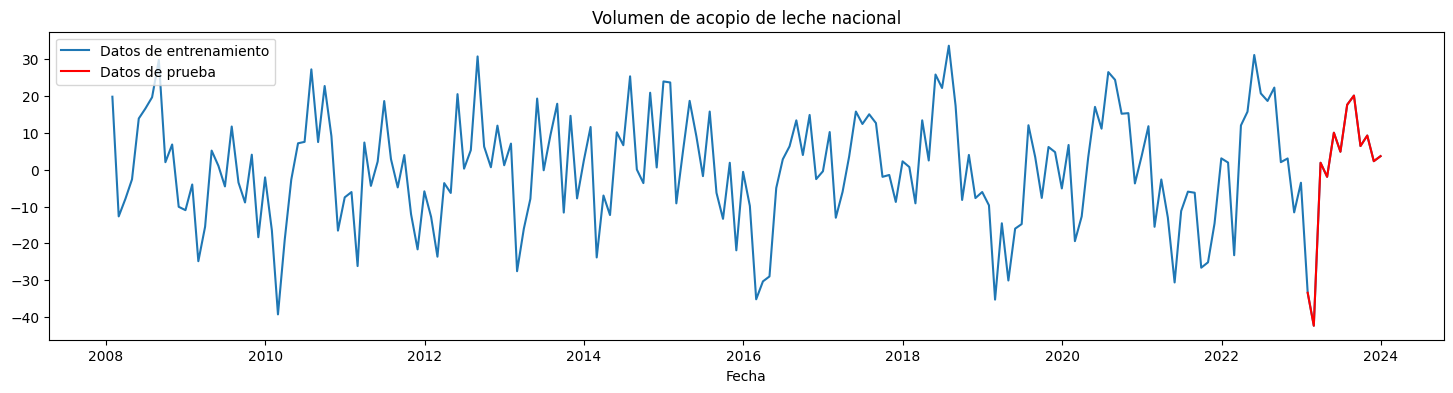

In [ ]:
leche_train = leche[0:-12]
leche_test = leche[-12:len(leche)]
plot.figure(figsize = (18,4))

# Datos de entrenamiento
plot.plot(leche.index, leche, label = 'Datos de entrenamiento')

# Datos de prueba
plot.plot(leche_test.index, leche_test, color='red', label='Datos de prueba')

# Leyenda
plot.title('Volumen de acopio de leche nacional')
plot.xlabel('Fecha')
plot.legend(loc = 'upper left')

## 🐮🐮 **Selección de rezagos**

En cuanto al entrenamiento del árbol:
- Usaremos la función `ForecasterAutoreg` del paquete `skforecast.ForecasterAutoreg`.
- Además del rezago de 12 meses intentaremos agregar otros rezagos para revisar distintos árboles:
    - Del 1 al 12 de forma secuencial.
    - 1, 6 y 12 meses.
    - 1, 3, 6,9 y 12 meses.
    - 1 y 12 meses.
    - 6 y 12 meses.
    - 4, 8 y 12 meses.
- Un problema presentado a lo largo del entrenamiento del árbol usando `grid search` es  que si definimos `initial_sample_size` como el 50% de los datos, el árbol nos va a generar un árbol que no genera "ramas" por eso se define búsqueda de profundidades y un tamaño del conjunto de datos en cada hoja del árbol mínimo (En este caso de forma arbitraria, escogemos la mínima cantidad de muestras en base a el número de años del set de datos).

In [ ]:
rezagos = [1,2,3,4,5,6,7,8,9,10,11,12,
          [1,6,12],
          [1,3,6,9,12],
          [1,12],
          [6,12],
          [4,8,12]]
hiperparametros = {'max_depth': list(range(5, 11)),
                   'min_samples_leaf': list(range(5,11))}
#hiperparametro = {'min_samples_leaf': list(range(1,15))}
#
# hiperparametros ={'max_depth': list(range(1, 15)),
#                 'min_samples_leaf': list(range(6,15)),
#                 'ccp_alpha': list(np.arange(0,1.01,0.01))}

Una vez definidos estos, creamos un árbol inicial:

In [ ]:
tree_leche = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 1305),
    lags = 6 # Este valor posiblemente cambiará con la busquéda de hiperparámetros
)

Por el momento, sólo buscaremos los mejores modelos de árbol un paso adelante:

In [ ]:
tuning = grid_search_forecaster(
    forecaster = tree_leche,
    y = leche_train,
    param_grid = hiperparametros,
    lags_grid = rezagos,
    steps = 1,
    refit = True,
    metric = 'mean_squared_error',
    initial_train_size = int(len(leche_train) * 0.8),
    fixed_train_size = False,
    return_best = True,
    verbose = False,
    show_progress = True)

Number of models compared: 612.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 7, 'min_samples_leaf': 8}
  Backtesting metric: 125.9081336572329



El modelo que mejor se desempeña en el conjunto de entrenamiento es tanto en MSE como en simplicidad del modelo es:

In [ ]:
tuning = tuning.sort_values(by = ['mean_squared_error', 'max_depth', 'min_samples_leaf'])
tuning

,lags,lags_label,params,mean_squared_error,max_depth,min_samples_leaf
117,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",125.908134,6,8
123,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 7, 'min_samples_leaf': 8}",125.908134,7,8
129,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 8, 'min_samples_leaf': 8}",125.908134,8,8
135,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 9, 'min_samples_leaf': 8}",125.908134,9,8
141,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 10, 'min_samples_leaf': 8}",125.908134,10,8
...,...,...,...,...,...,...
574,"[6, 12]","[6, 12]","{'max_depth': 10, 'min_samples_leaf': 9}",382.931601,10,9
555,"[6, 12]","[6, 12]","{'max_depth': 7, 'min_samples_leaf': 8}",386.675996,7,8
561,"[6, 12]","[6, 12]","{'max_depth': 8, 'min_samples_leaf': 8}",386.675996,8,8
567,"[6, 12]","[6, 12]","{'max_depth': 9, 'min_samples_leaf': 8}",386.675996,9,8


Como la idea es comparar entre árboles de decisión, filtro exponencial y modelos de redes neuronales guardaremos el mejor modelo de cada uno de los métodos en tuning:

In [ ]:
tuning = tuning[0:1]
tuning['model'] = 'decission tree'
tuning

,lags,lags_label,params,mean_squared_error,max_depth,min_samples_leaf,model
117,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",125.908134,6,8,decission tree


## 🐮🐮 **Estructura del árbol**

El rezago más importante para la predicción en este caso es el primer rezago:

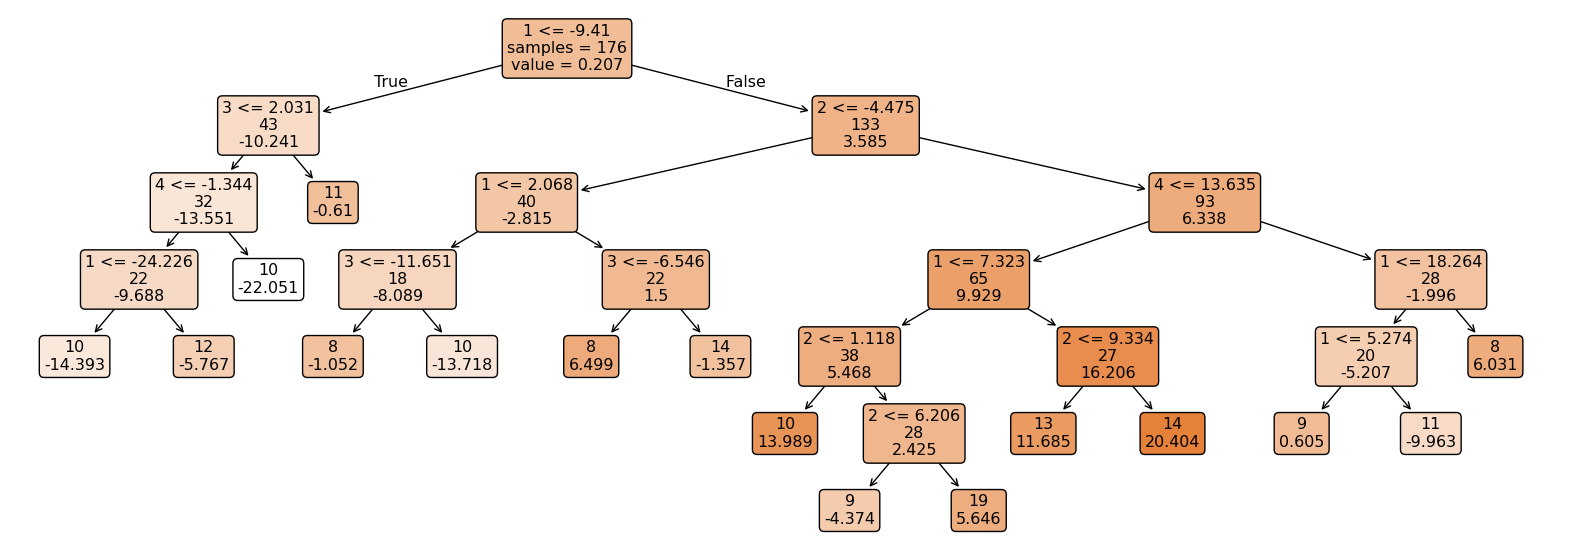

In [ ]:
# Crear una visualización del árbol
plot.figure(figsize=(20,7))
plot_tree(tree_leche.regressor, #max_depth = 5,
          filled=True, feature_names=tree_leche.lags, rounded = True,
          impurity = False, label = 'root')
plot.show()

In [ ]:
tree_leche.get_feature_importances()['importance']

0    0.498503
1    0.209036
3    0.179916
2    0.112545
Name: importance, dtype: float64

## 🐮🐮 **Modelo final**

Necesitamos reajustar el modelo pues aunque el argumento `refit` se haya dejado como `True` en este momento el árbol tiene profundidad siete:

In [ ]:
tree_leche = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 1305, max_depth=6, min_samples_leaf=8),
    lags = 4
)

tree_leche.fit(leche_train)

### 🐮🐮🐮 **Predicciones puntuales:**

In [ ]:
predicciones = tree_leche.predict(12)
predicciones

2023-01-31   -13.717527
2023-02-28   -22.050587
2023-03-31    -5.766836
2023-04-30    -1.052446
2023-05-31    -1.052446
2023-06-30    13.988646
2023-07-31    11.685102
2023-08-31    20.403882
2023-09-30    20.403882
2023-10-31     6.030851
2023-11-30     5.645758
2023-12-31    -9.962755
Freq: ME, Name: pred, dtype: float64

In [ ]:
MSE = mean_squared_error(y_true = leche_test, y_pred =predicciones)

tuning['MSE test'] =  MSE
tuning

,lags,lags_label,params,mean_squared_error,max_depth,min_samples_leaf,model,MSE test
117,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",125.908134,6,8,decission tree,125.298602


Teniendo en cuenta que la tendencia de estos datos ha sido ajustada usando regresión kernel. Debemos devolver los datos a su escala original:

In [ ]:
%%R -o ModeloKernelLeche
str(ModeloKernelLeche)

List of 2
 $ x: num [1:192] 2008 2008 2008 2008 2008 ...
 $ y: num [1:192] 226 226 225 225 225 ...


En `python` este objeto queda guardado como un diccionario:

In [ ]:
type(ModeloKernelLeche)

rpy2.rlike.container.OrdDict

In [ ]:
# Devolviendo los datos a su estado con tendencia
leche_train = leche_train + ModeloKernelLeche['y'][0:-12]
leche_test = leche_test + ModeloKernelLeche['y'][-13:-1]
leche = leche + ModeloKernelLeche['y']

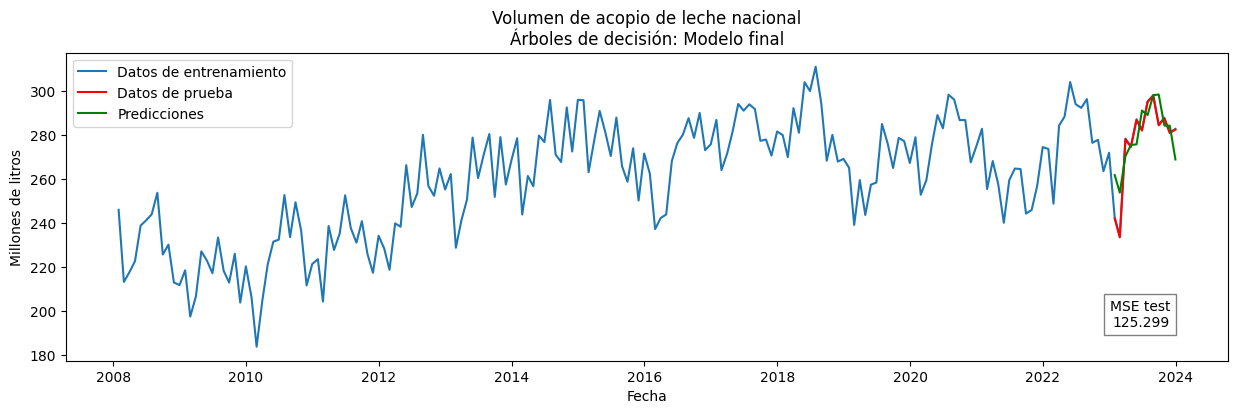

In [ ]:
plot.figure(figsize=(15,4))

# Datos de entrenamiento
plot.plot(leche.index, leche, label = 'Datos de entrenamiento')

# Datos de prueba
plot.plot(leche_test.index, leche_test, color='red', label = 'Datos de prueba')

# Predicciones
plot.plot(leche_test.index, (predicciones + ModeloKernelLeche['y'][-13:-1]),
          color = 'green', label = 'Predicciones')

# Leyenda
plot.title('Volumen de acopio de leche nacional\nÁrboles de decisión: Modelo final')
plot.xlabel('Fecha')
plot.ylabel('Millones de litros')
plot.legend(loc = 'upper left')

# Valor de MSE
plot.text(0.95,0.1, f'MSE test\n{MSE:.3f}', horizontalalignment='right', verticalalignment='bottom',
          transform=plot.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plot.show()

### 🐮🐮🐮 **Predicciones de intervalo:**

In [ ]:
intervalos = tree_leche.predict_interval(steps = 12,
                           interval = [0.025, 99.75],
                           n_boot = 1000)
for i in intervalos.keys():
    intervalos[i] = intervalos[i] + ModeloKernelLeche['y'][-13:-1]

intervalos

,pred,lower_bound,upper_bound
2023-01-31,261.613119,236.504355,293.808375
2023-02-28,253.623795,228.515032,310.718952
2023-03-31,270.243069,237.214431,308.750931
2023-04-30,275.284724,237.315889,315.479944
2023-05-31,275.603426,238.310467,316.915992
2023-06-30,290.955420,230.606687,318.002388
2023-07-31,288.955314,237.825464,325.531757
2023-08-31,297.970097,232.820033,324.271371
2023-09-30,298.259376,233.109312,317.251185
2023-10-31,284.169445,238.366368,318.802381


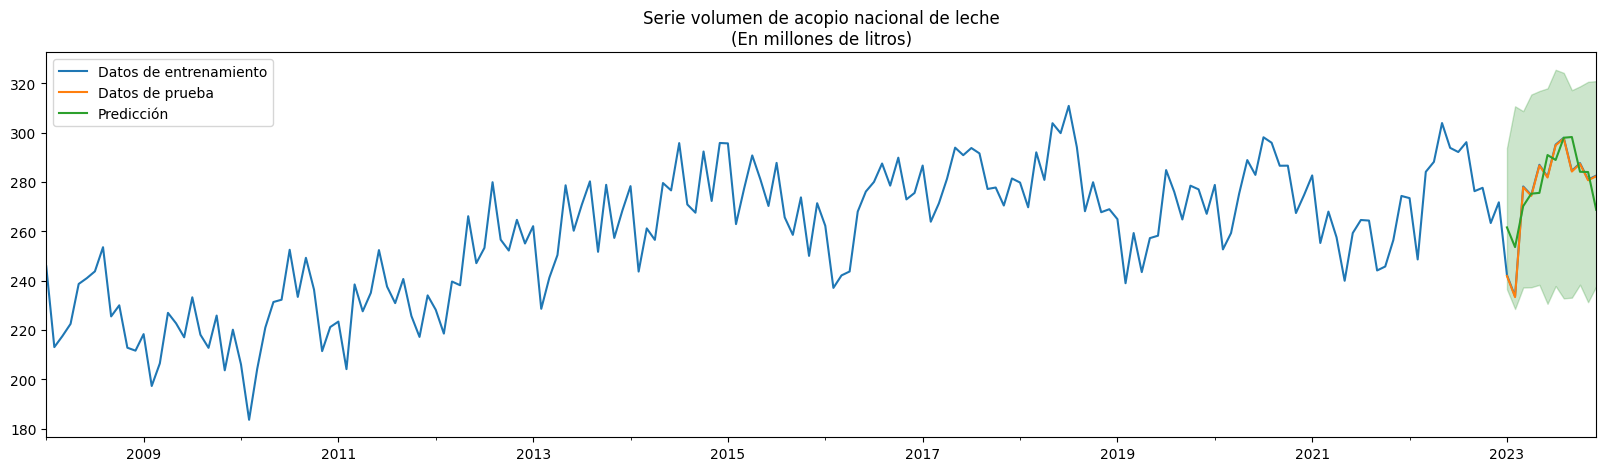

In [ ]:
fig, ax = plot.subplots(figsize=(20,5))
leche.plot(ax=ax, label = 'Datos de entrenamiento')
leche_test.plot(ax=ax, label = 'Datos de prueba')
intervalos['pred'].plot(ax=ax, label = 'Predicción')
ax.fill_between(
    intervalos.index,
    intervalos['lower_bound'],
    intervalos['upper_bound'],
    color = 'green',
    alpha = 0.2
)
plot.title('Serie volumen de acopio nacional de leche\n(En millones de litros)')
ax.legend(loc = 'upper left')

---

# 🐮 **Filtro exponencial**

En este caso, utilizaremos los datos originales teniendo en cuenta que no han tenido que ser transformados para la estabilización de la varianza, pero del mismo modo que con los árboles de decisión usaremos 180 datos de entrenamiento y 12 datos de prueba pra poder comparar todos los modelos luego. Además de esto, cabe mencionar que la serie aparentemente ya nos ha dado señales de contar con cierta tendencia y estacionalidad  lo mejor sería utilizar un filtro exponencial que tenga en cuenta todas estas cosas, sin embargo, revisaremos todos los posibles modelos sólo para estar seguros:

In [ ]:
%%R -i leche_train,leche_test,leche
# Recuerde que en la sección de árboles de decisión devolvimos a los datos de volumen de acopio a su estado original
# por lo que para usarlos acá no es necesario realizar ninguna transformación extra:

parametros = expand.grid('beta' = list(F, NULL), 'gamma' = list(F, NULL), 'seasonal' = list('additive', 'multiplicative'))

leche = ts(leche, start = 2008, freq = 12)
leche_train = ts(leche_train, start = 2008, freq = 12)
leche_test = ts(leche_test, start = 2023, freq = 12)

In [ ]:
%%R -o exponentialFilter_leche
exponentialFilter_leche = data.frame(matrix(ncol = 6, nrow = nrow(parametros)))
colnames(exponentialFilter_leche) = c('alpha', 'beta', 'gamma', 'seasonal','MSE', 'MSE test')
for (i in 1:nrow(parametros)){
    modeloExponencial = stats::HoltWinters(x = leche_train,
                                           alpha = NULL,
                                           beta = parametros$beta[[i]],
                                           gamma = parametros$gamma[[i]],
                                           seasonal = parametros$seasonal[[i]])
    # seasonal sólo debería tenerse en cuenta cuando se tiene un valor distinto a FALSE para gamma
    exponentialFilter_leche[i, c('alpha', 'beta', 'gamma', 'seasonal')] = c(modeloExponencial$alpha,
                                                                          modeloExponencial$beta,
                                                                          modeloExponencial$gamma,
                                                                          modeloExponencial$seasonal)
    exponentialFilter_leche[i, 'MSE'] = mean((leche_train - modeloExponencial$fitted[,'xhat'])**2)
    prediccion = predict(modeloExponencial, 12)
    exponentialFilter_leche[i, 'MSE test'] = mean((leche_test - prediccion)**2)
}

In [ ]:
exponentialFilter_leche.sort_values(by = ['MSE', 'MSE test'])

,alpha,beta,gamma,seasonal,MSE,MSE test
3,0.497605659473481,FALSE,0.514877589216722,additive,137.128568,285.851844
4,0.517446588561401,0.0123159804595052,0.549867097378286,additive,140.874724,315.058967
7,0.486913011272521,FALSE,0.550123940781374,multiplicative,143.797830,316.588714
8,0.508497476713958,0.00887138134947941,0.587279613385264,multiplicative,147.623300,374.369435
1,0.54876896251921,FALSE,FALSE,additive,206.344397,380.374445
5,0.54876896251921,FALSE,FALSE,multiplicative,206.344397,380.374445
2,0.723029544159567,0.193226060872,FALSE,additive,275.903286,986.130199
6,0.723029544159567,0.193226060872,FALSE,multiplicative,275.903286,986.130199


De estos modelos, el mejor modelo parece ser aquel en el que se incluye un componente de estacionariedad y de nivel, pero no uno de tendencia.

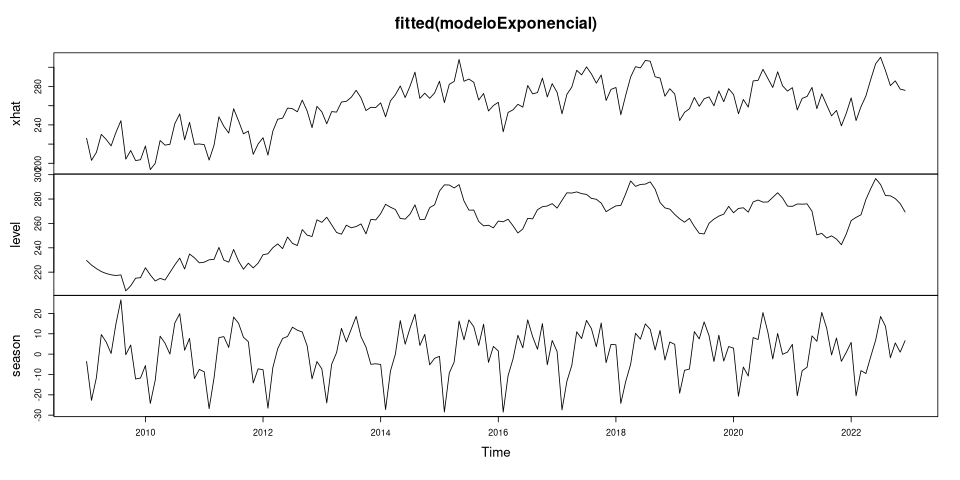

In [ ]:
%%R  -w 12 -h 6 --units in -r 80
modeloExponencial = stats::HoltWinters(leche_train,
                                      beta = FALSE,
                                      seasonal = 'additive')
plot(fitted(modeloExponencial))

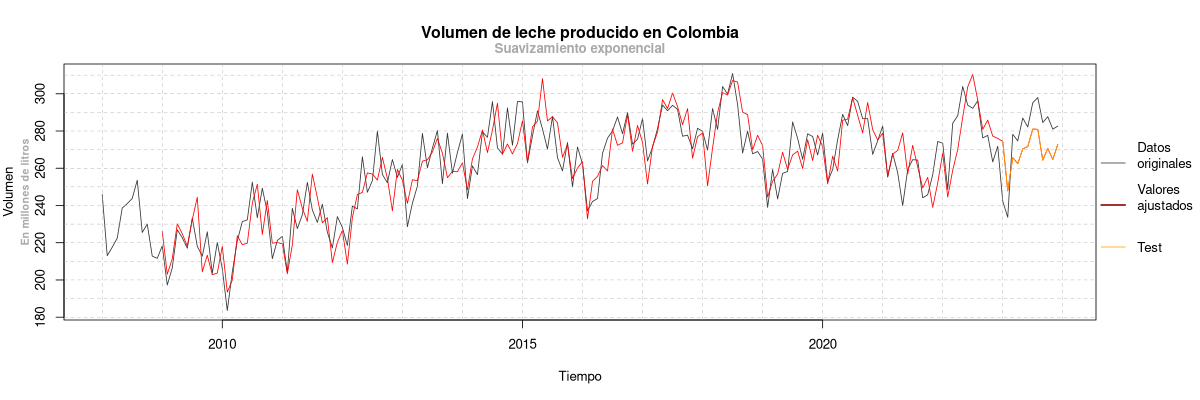

In [ ]:
%%R  -w 15 -h 5 --units in -r 80
par(mar = c(5,4,4,6.5))
plot.ts(leche, col = 'gray21',
        main = 'Volumen de leche producido en Colombia',
        # sub = 'En millones de litros',
        ylab = 'Volumen',
        xlab = 'Tiempo')
lines(x = time(leche)[13:length(leche)], y = c(modeloExponencial$fitted[,'xhat'], predict(modeloExponencial, 12)), col = 'red')
mtext(bquote(bold('En millones de litros')), side = 2, line = 2, adj = 0.5, cex = 0.8, col = 'darkgray')
mtext(bquote(bold('Suavizamiento exponencial')), side = 3, line = 0.3, adj = 0.5, cex = 1, col = 'darkgray')
abline(v = 2007:2025, col = 'darkgray', lty = 2, lwd = 0.5)
abline(h = seq(180,320, by = 10), col = 'darkgray', lty = 2, lwd = 0.5)
lines(x = time(leche)[181:192], y = predict(modeloExponencial,12), col = 'orange')
legend('right',legend = c('Datos\noriginales\n', 'Valores\najustados\n', 'Test'), col = c('gray21', 'darkred', 'orange'), lty = 1,
       xpd = T, inset = c(-0.1, 0), bty = 'n', lwd= c(1,2))

Sin embargo, no sobra estudiar la inclusión de un factor de amortigüamiento para revisar si el problema con la tendencia es su comportamiento de crecer o decrecer indefinidamente:

In [ ]:
%%R
modeloExponencial = forecast::hw(leche_train,
                                damped = TRUE,
                                seasonal = 'additive')
predicciones = forecast::forecast(modeloExponencial, h = 12)
cat(rep('=', 80),end = '\n', sep = '')
cat('Para el conjunto de prueba el MSE es: ', mean((predicciones$mean - leche_test)**2), end = ' \n')
cat('Y para el conjunto de entrenamiento es: ', modeloExponencial$model[['mse']], '\n')
cat(rep('=', 80),end = '\n', sep = '')

Para el conjunto de prueba el MSE es:  201.5516  
Y para el conjunto de entrenamiento es:  99.07363 


In [ ]:
%%R
modeloExponencial = forecast::hw(leche_train,
                                damped = TRUE,
                                seasonal = 'multiplicative')
predicciones = forecast::forecast(modeloExponencial, h = 12)
cat(rep('=', 80),end = '\n', sep = '')
cat('Para el conjunto de prueba el MSE es: ', mean((predicciones$mean - leche_test)**2), end = ' \n')
cat('Y para el conjunto de entrenamiento es: ', modeloExponencial$model[['mse']], '\n')
cat(rep('=', 80),end = '\n', sep = '')

Para el conjunto de prueba el MSE es:  191.7138  
Y para el conjunto de entrenamiento es:  100.2216 


In [ ]:
%%R
modeloExponencial = forecast::hw(leche_train,
                                damped = TRUE,
                                seasonal = 'multiplicative',
                                exponential = TRUE)
predicciones = forecast::forecast(modeloExponencial, h = 12)
cat(rep('=', 80),end = '\n', sep = '')
cat('Para el conjunto de prueba el MSE es: ', mean((predicciones$mean - leche_test)**2), end = ' \n')
cat('Y para el conjunto de entrenamiento es: ', modeloExponencial$model[['mse']], '\n')
cat(rep('=', 80),end = '\n', sep = '')

Para el conjunto de prueba el MSE es:  205.7556  
Y para el conjunto de entrenamiento es:  99.68759 


## 🐮🐮 Modelo final

Teniendo en cuenta todo lo anterior, el mejor modelo exponencial parece ser aquel con un componente de tendencia amortigüado. A continuación ajustamos el modelo:

In [ ]:
%%R
modeloExponencial = forecast::hw(leche_train,
                                damped = TRUE,
                                seasonal = 'multiplicative')

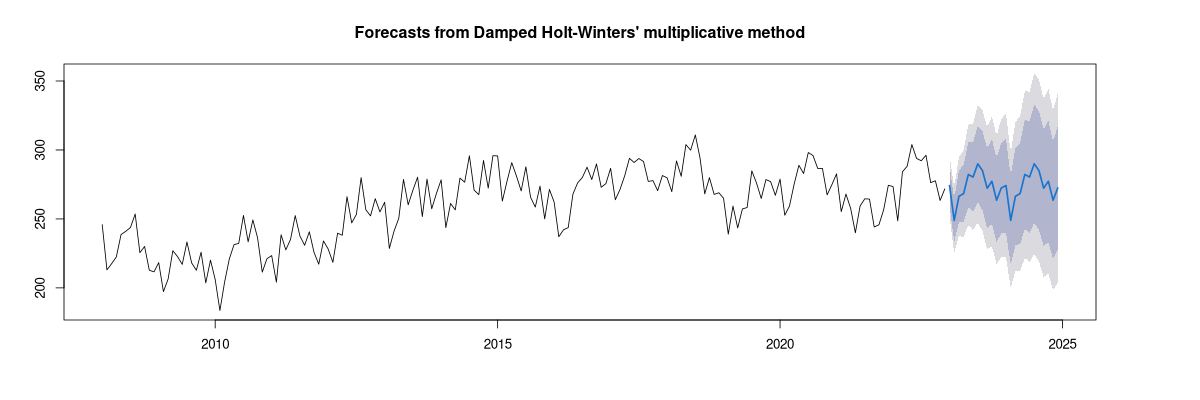

In [ ]:
%%R  -w 15 -h 5 --units in -r 80
par(mar = c(5,4,4,6.5))
plot(modeloExponencial)
# lines(x = time(leche)[12:190],y = c(modeloExponencial$fitted,modeloExponencial$mean[1]), col = 'darkred')
# lines(x = time(leche)[180:192], y = leche[180:192], col = 'black')
# mtext(bquote(bold('En millones de litros')), side = 2, line = 2, adj = 0.5, cex = 0.8, col = 'darkgray')
# mtext(bquote(bold('Suavizamiento exponencial')), side = 3, line = 0.3, adj = 0.5, cex = 1, col = 'darkgray')
# abline(v = 2007:2025, col = 'darkgray', lty = 2, lwd = 0.5)
# abline(h = seq(180,360, by = 10), col = 'darkgray', lty = 2, lwd = 0.5)
# legend('right',legend = c('Datos\noriginales\n', 'Valores\najustados\n', 'Test'), col = c('gray21', 'darkred', '#009ACD'), lty = 1,
#        xpd = T, inset = c(-0.1, 0), bty = 'n', lwd= c(1,2))

In [ ]:
%%R
modeloExponencial$fitted

          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
2008 237.3624 220.2154 231.0970 224.6497 234.9458 235.6986 247.1726 241.0325
2009 217.6518 197.9996 211.4819 210.0715 231.7379 224.8074 227.6785 227.2092
2010 219.0560 191.7385 199.9351 204.1327 225.4529 227.5486 238.3434 242.7979
2011 224.3162 203.1589 218.0732 232.2504 241.2795 235.9651 254.3898 240.0893
2012 232.1985 208.6023 229.7202 237.5663 250.2101 258.1788 260.0842 251.6583
2013 260.6837 237.4488 248.3906 245.9152 261.4888 270.1224 273.1909 267.1691
2014 269.4626 249.5190 263.2770 264.0329 272.9023 275.1204 285.4870 286.8222
2015 291.7868 267.0300 283.1471 281.7950 302.0938 287.4417 286.5377 282.4301
2016 269.1503 240.5366 255.1852 249.1689 258.5541 262.5250 280.0653 275.3076
2017 279.8549 257.8062 279.8713 276.8255 293.9901 291.9968 301.3059 291.7286
2018 281.8543 254.7208 282.3568 290.4549 299.3358 300.0556 310.1856 305.3575
2019 273.5819 243.5984 257.6799 260.6509 263.1507 257.8268 266.9050 273.0723

In [ ]:
%%R
summary(modeloExponencial)


Forecast method: Damped Holt-Winters' multiplicative method

Model Information:
Damped Holt-Winters' multiplicative method 

Call:
forecast::hw(y = leche_train, seasonal = "multiplicative", damped = TRUE)

  Smoothing parameters:
    alpha = 0.6062 
    beta  = 1e-04 
    gamma = 5e-04 
    phi   = 0.9799 

  Initial states:
    l = 236.5693 
    b = 0.0939 
    s = 0.9964 0.9638 1.0142 0.9958 1.0424 1.0604
           1.0254 1.0323 0.9816 0.9743 0.9105 1.003

  sigma:  0.0416

     AIC     AICc      BIC 
1805.401 1809.649 1862.874 

Error measures:
                   ME     RMSE      MAE         MPE     MAPE      MASE
Training set 0.295875 10.01107 7.929382 0.006586608 3.106075 0.4731381
                   ACF1
Training set -0.0425505

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2023       274.2006 259.5930 288.8083 251.8601 296.5412
Feb 2023       248.9051 233.3941 264.4160 225.1831 272.6270
Mar 2023       266.3639 247.6620 285.0659 237.7618 294.9660
Ap

In [ ]:
tuning = tuning.drop(columns = ['max_depth', 'min_samples_leaf', 'lags_label'])
tuning

,lags,params,mean_squared_error,model,MSE test
117,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",125.908134,decission tree,125.298602


In [ ]:
modeloExponencial = pd.DataFrame([[None, {'damped': True, 'seasonal': 'multiplicative'}, 100.2216, 'exponential smoothing', 191.7138]], columns = tuning.columns)
tuning = pd.concat([tuning,modeloExponencial])
tuning

,lags,params,mean_squared_error,model,MSE test
117,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",125.908134,decission tree,125.298602
0,None,"{'damped': True, 'seasonal': 'multiplicative'}",100.221600,exponential smoothing,191.713800


---

# 🐮 **Redes neuronales**

Como ya se mencionó anteriormente, la serie cuenta con muy pocos datos por lo que para el caso del entrenamiento de redes tampoco será posible utilizar datos de validación y se debe utilizar validación cruzada.


**Nota 4:** Debido a la carga computacional que se require cuando se habla de entrenamiento de redes los datos se vuelven a cargar desde 0 con el fin de poder migrar esta sección específica del avance a pcs con más recursos sin necesidad de modificar el código o servicios en la nube directamente como `Google Colab`.

**Nota 5:** Para trabajar en `Google Colab` se debe cambiar el `runtime type` a `T4 GPU` para realmente sacar ventaja de usarlo en cambio de un ordenador personal.

El objetivo de esta sección será similar a los revisados anteriormente: Revisar entre una serie de modelos cuál es el mejor modelo de redes para escogerlo como representante de esta sección y compararlo después con los modelos propuestos de filtros exponenciales y árboles de decisión. En este caso, utilizaremos los datos originales.

In [ ]:
!pip install skforecast
!pip install tensorflow
!pip install keras
!pip install scikit_learn
!pip install scikeras

In [2]:
# Manejo de datos en general
import pandas as pd
import numpy as np

# Para poder graficar
import matplotlib.pyplot as plot

# Escalado de los datos:
from sklearn.preprocessing import MinMaxScaler

#  Medidas de precisión
import tensorflow as tf

# Para búsqueda de hiperparámetros
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV


from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

## 🐮🐮 **Lectura de los datos**

Esta vez utilizando solamente `python` leemos los datos y los dividimos en entrenamiento y prueba justo cmo hicimos al inicio del cuaderno:

In [9]:
leche = pd.read_csv('https://raw.githubusercontent.com/Mendivenson/Series-de-tiempo/main/Datos/Volumen%20de%20Acopio%20Total%20%20(2008%20-%202023).csv')
leche = leche['NACIONAL'].values/1000000
date_index = pd.date_range(start = '2008-01', periods = len(leche), freq = 'M')
leche = pd.Series(leche, index = date_index)
leche_train = leche[0:-12]
leche_test = leche[-12:len(leche)]

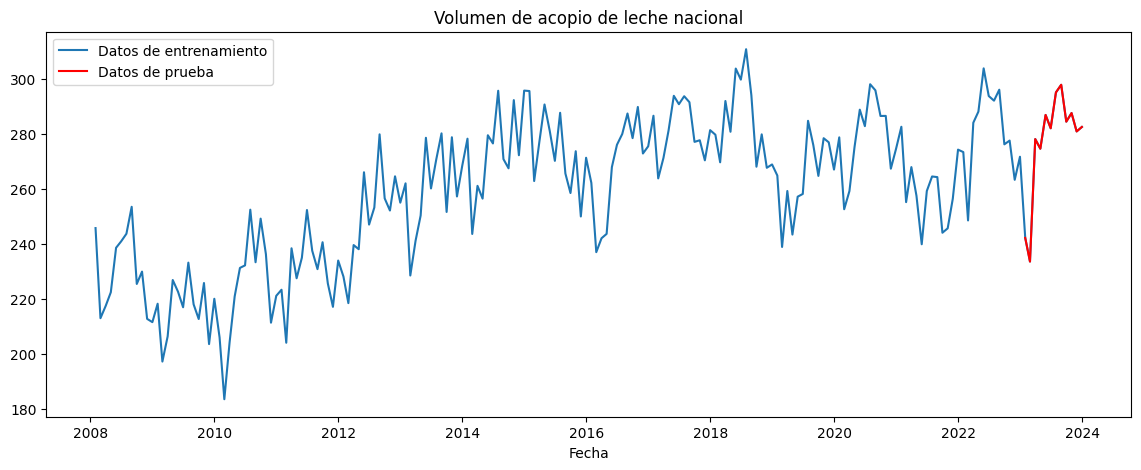

In [10]:
# @title Datos de entrenamiento y prueba {"display-mode":"form"}
plot.figure(figsize = (14,5))

# Datos de entrenamiento
plot.plot(leche.index, leche, label = 'Datos de entrenamiento')

# Datos de prueba
plot.plot(leche_test.index, leche_test, color='red', label='Datos de prueba')

# Leyenda
plot.title('Volumen de acopio de leche nacional')
plot.xlabel('Fecha')
plot.legend(loc = 'upper left')
plot.show()

## 🐮🐮 **Preparación de los datos**

Teniendo en cuenta que, en este caso, a la serie solamente se le asignarán covariables que serán rezagos de sí misma, empezamos con un escalado general de los datos de entrenamiento y prueba. En este caso, en cambio de usar la normalización como la serie presenta tendencia es mejor usar el escalado de la función `MinMaxScaler` de `sklearn`:

In [11]:
leche_train = MinMaxScaler().fit_transform(leche_train.values.reshape(-1,1))
leche_test = MinMaxScaler().fit_transform(leche_test.values.reshape(-1,1))

In [12]:
leche_train[0:4]

array([[0.48898113],
       [0.23149678],
       [0.26683114],
       [0.30555765]])

In [13]:
leche_test[0:4]

array([[0.13377034],
       [0.        ],
       [0.69287463],
       [0.63850573]])

## 🐮🐮 **Selección de covariables**

En lo que respecta a la selección de variables que usaremos. Tendremos en consideración dos cosas:

- El modelo de árboles ya nos ayuda a notar que los 4 meses anteriores parecen ser los de mayor importancia para la predicción 1 paso adelante usando esa metodología.

- Al mismo tiempo, el periodograma nos dió señales de cierta estacionariedad de frecuencia anual.

- Teniendo en cuenta que si deseamos utilizar el rezago anual como covariable para nuestra red neuronal de todas formas terminaremos perdiendo los doce datos, es mejor incluir doce rezagos de una sola vez. Aún así, es prudente revisar si con menos rezagos el modelo puede obtener un comportamiento similar al de doce rezagos.

In [14]:
# Tomando prestada la función que vimos en clase para crear
# el dataframe con las covariables deseadas:

def get_lagged_features(df, n_steps = 12, n_steps_ahead = 1):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []

    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [15]:
leche_train = pd.DataFrame(leche_train)
x_leche_train = get_lagged_features(leche_train)
y_leche_train = leche_train.values[1 + 12 - 1:]
y_train_timestamps = leche_train.index[1 + 12 - 1:]
leche_test = pd.DataFrame(leche_test)
x_leche_test = get_lagged_features(leche_test)
y_leche_test = leche_test.values[1 + 12 - 1:]
y_test_timestamps = leche_test.index[1 + 12 - 1:]

In [16]:
print([tensor.shape for tensor in (x_leche_train, y_leche_train, x_leche_test, y_leche_test)])

[(168, 12, 1), (168, 1), (0, 12, 1), (0, 1)]


## 🐮🐮 **Modelos a compararar**

Siguiendo la metodología para la aplicación de la metodología de validación cruzada, se propondrán los siguientes modelos:

- Red de una sola capa oculta
- Red multicapa de 3 capas ocultas
- Red recurrente simple
- Red recurrente simple + 2 capas ocultas
- Red GRU
- Red GRU + 2 capas ocultas
- Red LSTM
- Red LSTM + 2 capas ocultas

Por la cantidad de datos de la serie, es probable que las redes tiendan al sobreajuste por lo que en todas las redes se agrega un regularizador.

In [18]:
# REDES NEURONALES MULTICAPA
#def NNM(n_units = 10, l1_reg = 0, l2_reg = 0, seed = 1305):
#  model = keras.models.Sequential()
#  model.add(keras.layers.Dense(n_units, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed),  kernel_regularizer=keras.regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg), input_shape=(x_leche_train.shape[1], x_leche_train.shape[-1])))
#  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg)))
#  model.compile(loss='mean_squared_error', optimizer='adam')
#  return model

#def NNM3(n_units = 10, l1_reg = 0, l2_reg = 0, seed = 1305):
#  model = keras.models.Sequential()
#  model.add(keras.layers.Dense(n_units, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed),  kernel_regularizer=keras.regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg), input_shape=(x_leche_train.shape[1], x_leche_train.shape[-1])))
#  model.add(keras.layers.Dense(n_units, activation= 'linear', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed),  kernel_regularizer=keras.regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg)))
#  model.add(keras.layers.Dense(n_units, activation= 'linear ', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed),  kernel_regularizer=keras.regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg)))
#  model.add(keras.layers.Dense(1,activation='sigmoid',kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg)))
#  model.compile(loss='mean_squared_error', optimizer='adam')
#  return model

def NNM(n_units = 10, l1_reg = 0,  seed = 1305):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(n_units, activation='relu',
                               kernel_initializer=keras.initializers.glorot_uniform(seed),
                               bias_initializer=keras.initializers.glorot_uniform(seed),
                               kernel_regularizer=l1(l1_reg),
                               input_shape=(x_leche_train.shape[1], x_leche_train.shape[-1])))
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed),
                               bias_initializer=keras.initializers.glorot_uniform(seed),
                               kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
def NNM3(n_units = 10, l1_reg = 0, seed = 1305):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(n_units, activation='relu',
                               kernel_initializer=keras.initializers.glorot_uniform(seed),
                               bias_initializer=keras.initializers.glorot_uniform(seed),
                               kernel_regularizer=l1(l1_reg),
                               input_shape=(x_leche_train.shape[1], x_leche_train.shape[-1])))
  model.add(keras.layers.Dense(n_units, activation= 'linear',
                               kernel_initializer=keras.initializers.glorot_uniform(seed),
                               bias_initializer=keras.initializers.glorot_uniform(seed),
                               kernel_regularizer=l1(l1_reg)))
  model.add(keras.layers.Dense(n_units, activation= 'linear ',
                               kernel_initializer=keras.initializers.glorot_uniform(seed),
                               bias_initializer=keras.initializers.glorot_uniform(seed),
                               kernel_regularizer=l1(l1_reg)))
  model.add(keras.layers.Dense(1,activation='sigmoid',
                               kernel_initializer=keras.initializers.glorot_uniform(seed),
                               bias_initializer=keras.initializers.glorot_uniform(seed),
                               kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [19]:
params = {
      'nnm': {
          'model': None, 'function': NNM, 'l1_reg': 0.0,'H': 20,
          'color': 'blue', 'label':'NNM'}
      }

In [21]:
# CROSS-VALIDATION
max_epochs = 50
batch_size = 12
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3, min_delta=1e-7, restore_best_weights=True)
n_units = [5, 10, 20, 30]
l1_reg = [0, 0.001, 0.01, 0.1]
# l2_reg =  [0, 0.001, 0.01, 0.1]
# A dictionary containing a list of values to be iterated through
# for each parameter of the model included in the search
param_grid = {'model__n_units': n_units, 'model__l1_reg': l1_reg}

# In the kth split, TimeSeriesSplit returns first k folds
# as training set and the (k+1)th fold as test set.
tscv = TimeSeriesSplit(n_splits = 2)

# A grid search is performed for each of the models, and the parameter set which
# performs best over all the cross-validation splits is saved in the `params` dictionary
for key in params.keys():
    print('Performing cross-validation. Model:', key)
    model = KerasRegressor(model=params[key]['function'], epochs=max_epochs,
                           batch_size=batch_size, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        cv=tscv, n_jobs=1, verbose=2)
    grid_result = grid.fit(x_leche_train, y_leche_train, callbacks=[es])
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params_ = grid_result.cv_results_['params']
    for mean, stdev, param_ in zip(means, stds, params_):
        print("%f (%f) with %r" % (mean, stdev, param_))
    params[key]['H'] = grid_result.best_params_['n_units']
    params[key]['l1_reg'] = grid_result.best_params_['l1_reg']
    params[key]['l2_reg'] = grid_result.best_params_['l2_reg']

Performing cross-validation. Model: nnm
Fitting 2 folds for each of 16 candidates, totalling 32 fits
Epoch 1/50
[CV] END ..................model__l1_reg=0, model__n_units=5; total time=   0.1s
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END ..................model__l1_reg=0, model__n_units=5; total time=   0.1s
Epoch 1/50
[CV] END .................model__l1_reg=0, model__n_units=10; total time=   0.1s
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END .................model__l1_reg=0, model__n_units=10; total time=   0.1s
Epoch 1/50
[CV] END .................model__l1_reg=0, model__n_units=20; total time=   0.1s
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END .................model__l1_reg=0, model__n_units=20; total time=   0.1s
Epoch 1/50
[CV] END .................model__l1_reg=0, model__n_units=30; total time=   0.1s
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END .................model__l1_reg=0, model__n_units=30; total time=   0.1s
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 - 2s - 314ms/step - loss: 0.0461
Epoch 2/50
5/5 - 0s - 6ms/step - loss: 0.0431
Epoch 3/50
5/5 - 0s - 5ms/step - loss: 0.0404
Epoch 4/50
5/5 - 0s - 5ms/step - loss: 0.0381
Epoch 5/50
5/5 - 0s - 5ms/step - loss: 0.0357
Epoch 6/50
5/5 - 0s - 5ms/step - loss: 0.0341
Epoch 7/50
5/5 - 0s - 5ms/step - loss: 0.0327
Epoch 8/50
5/5 - 0s - 5ms/step - loss: 0.0311
Epoch 9/50
5/5 - 0s - 5ms/step - loss: 0.0304
Epoch 10/50
5/5 - 0s - 5ms/step - loss: 0.0296
Epoch 11/50
5/5 - 0s - 5ms/step - loss: 0.0289
Epoch 12/50
5/5 - 0s - 5ms/step - loss: 0.0284
Epoch 13/50
5/5 - 0s - 11ms/step - loss: 0.0282
Epoch 14/50
5/5 - 0s - 11ms/step - loss: 0.0279
Epoch 15/50
5/5 - 0s - 4ms/step - loss: 0.0276
Epoch 16/50
5/5 - 0s - 12ms/step - loss: 0.0275
Epoch 17/50
5/5 - 0s - 5ms/step - loss: 0.0274
Epoch 18/50
5/5 - 0s - 12ms/step - loss: 0.0273
Epoch 19/50
5/5 - 0s - 11ms/step - loss: 0.0273
Epoch 20/50
5/5 - 0s - 12ms/step - loss: 0.0273
Epoch 21/50
5/5 - 0s - 5ms/step - loss: 0.0272
Epoch 22/50
5/5 - 0s - 5m

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 231ms/step - loss: 0.0894
Epoch 2/50
10/10 - 1s - 120ms/step - loss: 0.0777
Epoch 3/50
10/10 - 0s - 3ms/step - loss: 0.0675
Epoch 4/50
10/10 - 0s - 6ms/step - loss: 0.0588
Epoch 5/50
10/10 - 0s - 3ms/step - loss: 0.0515
Epoch 6/50
10/10 - 0s - 3ms/step - loss: 0.0456
Epoch 7/50
10/10 - 0s - 3ms/step - loss: 0.0414
Epoch 8/50
10/10 - 0s - 6ms/step - loss: 0.0378
Epoch 9/50
10/10 - 0s - 3ms/step - loss: 0.0354
Epoch 10/50
10/10 - 0s - 3ms/step - loss: 0.0336
Epoch 11/50
10/10 - 0s - 3ms/step - loss: 0.0325
Epoch 12/50
10/10 - 0s - 3ms/step - loss: 0.0317
Epoch 13/50
10/10 - 0s - 3ms/step - loss: 0.0311
Epoch 14/50
10/10 - 0s - 3ms/step - loss: 0.0308
Epoch 15/50
10/10 - 0s - 3ms/step - loss: 0.0306
Epoch 16/50
10/10 - 0s - 3ms/step - loss: 0.0304
Epoch 17/50
10/10 - 0s - 6ms/step - loss: 0.0302
Epoch 18/50
10/10 - 0s - 6ms/step - loss: 0.0301
Epoch 19/50
10/10 - 0s - 3ms/step - loss: 0.0301
Epoch 20/50
10/10 - 0s - 3ms/step - loss: 0.0300
Epoch 21/50
10/10 - 0s - 3ms/step - 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 2s - 325ms/step - loss: 0.1101
Epoch 2/50
5/5 - 0s - 7ms/step - loss: 0.0973
Epoch 3/50
5/5 - 0s - 5ms/step - loss: 0.0853
Epoch 4/50
5/5 - 0s - 5ms/step - loss: 0.0756
Epoch 5/50
5/5 - 0s - 5ms/step - loss: 0.0667
Epoch 6/50
5/5 - 0s - 4ms/step - loss: 0.0594
Epoch 7/50
5/5 - 0s - 4ms/step - loss: 0.0532
Epoch 8/50
5/5 - 0s - 6ms/step - loss: 0.0481
Epoch 9/50
5/5 - 0s - 5ms/step - loss: 0.0440
Epoch 10/50
5/5 - 0s - 5ms/step - loss: 0.0406
Epoch 11/50
5/5 - 0s - 5ms/step - loss: 0.0380
Epoch 12/50
5/5 - 0s - 5ms/step - loss: 0.0358
Epoch 13/50
5/5 - 0s - 5ms/step - loss: 0.0342
Epoch 14/50
5/5 - 0s - 5ms/step - loss: 0.0330
Epoch 15/50
5/5 - 0s - 6ms/step - loss: 0.0321
Epoch 16/50
5/5 - 0s - 12ms/step - loss: 0.0313
Epoch 17/50
5/5 - 0s - 5ms/step - loss: 0.0307
Epoch 18/50
5/5 - 0s - 5ms/step - loss: 0.0304
Epoch 19/50
5/5 - 0s - 5ms/step - loss: 0.0301
Epoch 20/50
5/5 - 0s - 5ms/step - loss: 0.0299
Epoch 21/50
5/5 - 0s - 5ms/step - loss: 0.0298
Epoch 22/50
5/5 - 0s - 5ms/ste

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 165ms/step - loss: 0.0810
Epoch 2/50
10/10 - 0s - 31ms/step - loss: 0.0606
Epoch 3/50
10/10 - 0s - 6ms/step - loss: 0.0470
Epoch 4/50
10/10 - 0s - 6ms/step - loss: 0.0385
Epoch 5/50
10/10 - 0s - 6ms/step - loss: 0.0341
Epoch 6/50
10/10 - 0s - 3ms/step - loss: 0.0319
Epoch 7/50
10/10 - 0s - 6ms/step - loss: 0.0311
Epoch 8/50
10/10 - 0s - 6ms/step - loss: 0.0308
Epoch 9/50
10/10 - 0s - 4ms/step - loss: 0.0306
Epoch 10/50
10/10 - 0s - 6ms/step - loss: 0.0305
Epoch 11/50
10/10 - 0s - 3ms/step - loss: 0.0304
Epoch 12/50
10/10 - 0s - 3ms/step - loss: 0.0303
Epoch 13/50
10/10 - 0s - 3ms/step - loss: 0.0302
Epoch 14/50
10/10 - 0s - 3ms/step - loss: 0.0301
Epoch 15/50
10/10 - 0s - 3ms/step - loss: 0.0300
Epoch 16/50
10/10 - 0s - 3ms/step - loss: 0.0300
Epoch 17/50
10/10 - 0s - 3ms/step - loss: 0.0299
Epoch 18/50
10/10 - 0s - 3ms/step - loss: 0.0298
Epoch 19/50
10/10 - 0s - 3ms/step - loss: 0.0297
Epoch 20/50
10/10 - 0s - 3ms/step - loss: 0.0296
Epoch 21/50
10/10 - 0s - 3ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 2s - 383ms/step - loss: 0.0347
Epoch 2/50
5/5 - 0s - 70ms/step - loss: 0.0339
Epoch 3/50
5/5 - 0s - 6ms/step - loss: 0.0333
Epoch 4/50
5/5 - 0s - 12ms/step - loss: 0.0332
Epoch 5/50
5/5 - 0s - 7ms/step - loss: 0.0331
Epoch 6/50
5/5 - 0s - 5ms/step - loss: 0.0330
Epoch 7/50
5/5 - 0s - 5ms/step - loss: 0.0329
Epoch 8/50
5/5 - 0s - 5ms/step - loss: 0.0327
Epoch 9/50
5/5 - 0s - 5ms/step - loss: 0.0326
Epoch 10/50
5/5 - 0s - 5ms/step - loss: 0.0325
Epoch 11/50
5/5 - 0s - 5ms/step - loss: 0.0324
Epoch 12/50
5/5 - 0s - 6ms/step - loss: 0.0323
Epoch 13/50
5/5 - 0s - 5ms/step - loss: 0.0323
Epoch 14/50
5/5 - 0s - 5ms/step - loss: 0.0321
Epoch 15/50
5/5 - 0s - 5ms/step - loss: 0.0321
Epoch 16/50
5/5 - 0s - 5ms/step - loss: 0.0319
Epoch 17/50
5/5 - 0s - 5ms/step - loss: 0.0318
Epoch 18/50
5/5 - 0s - 4ms/step - loss: 0.0317
Epoch 19/50
5/5 - 0s - 5ms/step - loss: 0.0316
Epoch 20/50
5/5 - 0s - 5ms/step - loss: 0.0315
Epoch 21/50
5/5 - 0s - 4ms/step - loss: 0.0314
Epoch 22/50
5/5 - 0s - 4ms/st

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 157ms/step - loss: 0.0361
Epoch 2/50
10/10 - 0s - 3ms/step - loss: 0.0352
Epoch 3/50
10/10 - 0s - 3ms/step - loss: 0.0349
Epoch 4/50
10/10 - 0s - 3ms/step - loss: 0.0346
Epoch 5/50
10/10 - 0s - 6ms/step - loss: 0.0344
Epoch 6/50
10/10 - 0s - 3ms/step - loss: 0.0340
Epoch 7/50
10/10 - 0s - 3ms/step - loss: 0.0338
Epoch 8/50
10/10 - 0s - 3ms/step - loss: 0.0335
Epoch 9/50
10/10 - 0s - 7ms/step - loss: 0.0333
Epoch 10/50
10/10 - 0s - 3ms/step - loss: 0.0330
Epoch 11/50
10/10 - 0s - 3ms/step - loss: 0.0329
Epoch 12/50
10/10 - 0s - 3ms/step - loss: 0.0325
Epoch 13/50
10/10 - 0s - 6ms/step - loss: 0.0323
Epoch 14/50
10/10 - 0s - 3ms/step - loss: 0.0321
Epoch 15/50
10/10 - 0s - 3ms/step - loss: 0.0319
Epoch 16/50
10/10 - 0s - 3ms/step - loss: 0.0317
Epoch 17/50
10/10 - 0s - 3ms/step - loss: 0.0314
Epoch 18/50
10/10 - 0s - 3ms/step - loss: 0.0313
Epoch 19/50
10/10 - 0s - 6ms/step - loss: 0.0311
Epoch 20/50
10/10 - 0s - 3ms/step - loss: 0.0308
Epoch 21/50
10/10 - 0s - 3ms/step - lo

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 2s - 322ms/step - loss: 0.0410
Epoch 2/50
5/5 - 0s - 80ms/step - loss: 0.0384
Epoch 3/50
5/5 - 0s - 12ms/step - loss: 0.0367
Epoch 4/50
5/5 - 0s - 11ms/step - loss: 0.0362
Epoch 5/50
5/5 - 0s - 5ms/step - loss: 0.0361
Epoch 6/50
5/5 - 0s - 11ms/step - loss: 0.0361
Epoch 7/50
5/5 - 0s - 5ms/step - loss: 0.0360
Epoch 8/50
5/5 - 0s - 12ms/step - loss: 0.0357
Epoch 9/50
5/5 - 0s - 5ms/step - loss: 0.0354
Epoch 10/50
5/5 - 0s - 12ms/step - loss: 0.0352
Epoch 11/50
5/5 - 0s - 12ms/step - loss: 0.0350
Epoch 12/50
5/5 - 0s - 12ms/step - loss: 0.0349
Epoch 13/50
5/5 - 0s - 5ms/step - loss: 0.0347
Epoch 14/50
5/5 - 0s - 5ms/step - loss: 0.0344
Epoch 15/50
5/5 - 0s - 5ms/step - loss: 0.0342
Epoch 16/50
5/5 - 0s - 12ms/step - loss: 0.0341
Epoch 17/50
5/5 - 0s - 13ms/step - loss: 0.0339
Epoch 18/50
5/5 - 0s - 7ms/step - loss: 0.0338
Epoch 19/50
5/5 - 0s - 11ms/step - loss: 0.0336
Epoch 20/50
5/5 - 0s - 12ms/step - loss: 0.0334
Epoch 21/50
5/5 - 0s - 12ms/step - loss: 0.0332
Epoch 22/50
5/5 - 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 162ms/step - loss: 0.0630
Epoch 2/50
10/10 - 0s - 42ms/step - loss: 0.0489
Epoch 3/50
10/10 - 0s - 6ms/step - loss: 0.0413
Epoch 4/50
10/10 - 0s - 3ms/step - loss: 0.0381
Epoch 5/50
10/10 - 0s - 3ms/step - loss: 0.0378
Epoch 6/50
10/10 - 0s - 3ms/step - loss: 0.0373
Epoch 7/50
10/10 - 0s - 3ms/step - loss: 0.0369
Epoch 8/50
10/10 - 0s - 4ms/step - loss: 0.0364
Epoch 9/50
10/10 - 0s - 3ms/step - loss: 0.0360
Epoch 10/50
10/10 - 0s - 3ms/step - loss: 0.0356
Epoch 11/50
10/10 - 0s - 3ms/step - loss: 0.0353
Epoch 12/50
10/10 - 0s - 6ms/step - loss: 0.0350
Epoch 13/50
10/10 - 0s - 3ms/step - loss: 0.0346
Epoch 14/50
10/10 - 0s - 6ms/step - loss: 0.0342
Epoch 15/50
10/10 - 0s - 6ms/step - loss: 0.0341
Epoch 16/50
10/10 - 0s - 3ms/step - loss: 0.0337
Epoch 17/50
10/10 - 0s - 3ms/step - loss: 0.0332
Epoch 18/50
10/10 - 0s - 3ms/step - loss: 0.0329
Epoch 19/50
10/10 - 0s - 6ms/step - loss: 0.0326
Epoch 20/50
10/10 - 0s - 3ms/step - loss: 0.0322
Epoch 21/50
10/10 - 0s - 6ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 2s - 311ms/step - loss: 0.0878
Epoch 2/50
5/5 - 0s - 80ms/step - loss: 0.0846
Epoch 3/50
5/5 - 0s - 5ms/step - loss: 0.0814
Epoch 4/50
5/5 - 0s - 5ms/step - loss: 0.0789
Epoch 5/50
5/5 - 0s - 5ms/step - loss: 0.0765
Epoch 6/50
5/5 - 0s - 5ms/step - loss: 0.0745
Epoch 7/50
5/5 - 0s - 5ms/step - loss: 0.0728
Epoch 8/50
5/5 - 0s - 5ms/step - loss: 0.0713
Epoch 9/50
5/5 - 0s - 5ms/step - loss: 0.0702
Epoch 10/50
5/5 - 0s - 12ms/step - loss: 0.0691
Epoch 11/50
5/5 - 0s - 5ms/step - loss: 0.0683
Epoch 12/50
5/5 - 0s - 5ms/step - loss: 0.0679
Epoch 13/50
5/5 - 0s - 5ms/step - loss: 0.0673
Epoch 14/50
5/5 - 0s - 12ms/step - loss: 0.0668
Epoch 15/50
5/5 - 0s - 11ms/step - loss: 0.0666
Epoch 16/50
5/5 - 0s - 5ms/step - loss: 0.0663
Epoch 17/50
5/5 - 0s - 12ms/step - loss: 0.0660
Epoch 18/50
5/5 - 0s - 7ms/step - loss: 0.0657
Epoch 19/50
5/5 - 0s - 6ms/step - loss: 0.0655
Epoch 20/50
5/5 - 0s - 6ms/step - loss: 0.0653
Epoch 21/50
5/5 - 0s - 11ms/step - loss: 0.0651
Epoch 22/50
5/5 - 0s - 5m

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 3s - 260ms/step - loss: 0.1310
Epoch 2/50
10/10 - 0s - 5ms/step - loss: 0.1189
Epoch 3/50
10/10 - 0s - 4ms/step - loss: 0.1081
Epoch 4/50
10/10 - 0s - 6ms/step - loss: 0.0993
Epoch 5/50
10/10 - 0s - 4ms/step - loss: 0.0917
Epoch 6/50
10/10 - 0s - 6ms/step - loss: 0.0858
Epoch 7/50
10/10 - 0s - 4ms/step - loss: 0.0814
Epoch 8/50
10/10 - 0s - 6ms/step - loss: 0.0777
Epoch 9/50
10/10 - 0s - 6ms/step - loss: 0.0748
Epoch 10/50
10/10 - 0s - 5ms/step - loss: 0.0726
Epoch 11/50
10/10 - 0s - 5ms/step - loss: 0.0712
Epoch 12/50
10/10 - 0s - 5ms/step - loss: 0.0699
Epoch 13/50
10/10 - 0s - 5ms/step - loss: 0.0689
Epoch 14/50
10/10 - 0s - 6ms/step - loss: 0.0684
Epoch 15/50
10/10 - 0s - 6ms/step - loss: 0.0677
Epoch 16/50
10/10 - 0s - 6ms/step - loss: 0.0672
Epoch 17/50
10/10 - 0s - 5ms/step - loss: 0.0667
Epoch 18/50
10/10 - 0s - 7ms/step - loss: 0.0663
Epoch 19/50
10/10 - 0s - 6ms/step - loss: 0.0659
Epoch 20/50
10/10 - 0s - 6ms/step - loss: 0.0654
Epoch 21/50
10/10 - 0s - 6ms/step - lo

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 2s - 333ms/step - loss: 0.1850
Epoch 2/50
5/5 - 0s - 65ms/step - loss: 0.1715
Epoch 3/50
5/5 - 0s - 5ms/step - loss: 0.1588
Epoch 4/50
5/5 - 0s - 5ms/step - loss: 0.1476
Epoch 5/50
5/5 - 0s - 5ms/step - loss: 0.1383
Epoch 6/50
5/5 - 0s - 6ms/step - loss: 0.1299
Epoch 7/50
5/5 - 0s - 11ms/step - loss: 0.1231
Epoch 8/50
5/5 - 0s - 5ms/step - loss: 0.1173
Epoch 9/50
5/5 - 0s - 12ms/step - loss: 0.1124
Epoch 10/50
5/5 - 0s - 5ms/step - loss: 0.1083
Epoch 11/50
5/5 - 0s - 5ms/step - loss: 0.1052
Epoch 12/50
5/5 - 0s - 12ms/step - loss: 0.1025
Epoch 13/50
5/5 - 0s - 5ms/step - loss: 0.1003
Epoch 14/50
5/5 - 0s - 11ms/step - loss: 0.0985
Epoch 15/50
5/5 - 0s - 12ms/step - loss: 0.0971
Epoch 16/50
5/5 - 0s - 5ms/step - loss: 0.0959
Epoch 17/50
5/5 - 0s - 13ms/step - loss: 0.0947
Epoch 18/50
5/5 - 0s - 10ms/step - loss: 0.0939
Epoch 19/50
5/5 - 0s - 5ms/step - loss: 0.0932
Epoch 20/50
5/5 - 0s - 12ms/step - loss: 0.0925
Epoch 21/50
5/5 - 0s - 12ms/step - loss: 0.0919
Epoch 22/50
5/5 - 0s 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 167ms/step - loss: 0.1555
Epoch 2/50
10/10 - 0s - 3ms/step - loss: 0.1336
Epoch 3/50
10/10 - 0s - 6ms/step - loss: 0.1182
Epoch 4/50
10/10 - 0s - 6ms/step - loss: 0.1082
Epoch 5/50
10/10 - 0s - 3ms/step - loss: 0.1027
Epoch 6/50
10/10 - 0s - 3ms/step - loss: 0.0994
Epoch 7/50
10/10 - 0s - 6ms/step - loss: 0.0976
Epoch 8/50
10/10 - 0s - 6ms/step - loss: 0.0963
Epoch 9/50
10/10 - 0s - 6ms/step - loss: 0.0954
Epoch 10/50
10/10 - 0s - 3ms/step - loss: 0.0945
Epoch 11/50
10/10 - 0s - 3ms/step - loss: 0.0936
Epoch 12/50
10/10 - 0s - 3ms/step - loss: 0.0928
Epoch 13/50
10/10 - 0s - 3ms/step - loss: 0.0919
Epoch 14/50
10/10 - 0s - 3ms/step - loss: 0.0911
Epoch 15/50
10/10 - 0s - 6ms/step - loss: 0.0903
Epoch 16/50
10/10 - 0s - 6ms/step - loss: 0.0894
Epoch 17/50
10/10 - 0s - 6ms/step - loss: 0.0886
Epoch 18/50
10/10 - 0s - 6ms/step - loss: 0.0876
Epoch 19/50
10/10 - 0s - 5ms/step - loss: 0.0868
Epoch 20/50
10/10 - 0s - 3ms/step - loss: 0.0859
Epoch 21/50
10/10 - 0s - 6ms/step - lo

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 3s - 691ms/step - loss: 0.1347
Epoch 2/50
5/5 - 1s - 147ms/step - loss: 0.1318
Epoch 3/50
5/5 - 0s - 5ms/step - loss: 0.1295
Epoch 4/50
5/5 - 0s - 5ms/step - loss: 0.1277
Epoch 5/50
5/5 - 0s - 11ms/step - loss: 0.1261
Epoch 6/50
5/5 - 0s - 12ms/step - loss: 0.1247
Epoch 7/50
5/5 - 0s - 6ms/step - loss: 0.1233
Epoch 8/50
5/5 - 0s - 5ms/step - loss: 0.1220
Epoch 9/50
5/5 - 0s - 5ms/step - loss: 0.1207
Epoch 10/50
5/5 - 0s - 5ms/step - loss: 0.1193
Epoch 11/50
5/5 - 0s - 5ms/step - loss: 0.1180
Epoch 12/50
5/5 - 0s - 5ms/step - loss: 0.1167
Epoch 13/50
5/5 - 0s - 6ms/step - loss: 0.1154
Epoch 14/50
5/5 - 0s - 12ms/step - loss: 0.1140
Epoch 15/50
5/5 - 0s - 11ms/step - loss: 0.1127
Epoch 16/50
5/5 - 0s - 5ms/step - loss: 0.1115
Epoch 17/50
5/5 - 0s - 5ms/step - loss: 0.1102
Epoch 18/50
5/5 - 0s - 5ms/step - loss: 0.1090
Epoch 19/50
5/5 - 0s - 5ms/step - loss: 0.1077
Epoch 20/50
5/5 - 0s - 12ms/step - loss: 0.1066
Epoch 21/50
5/5 - 0s - 5ms/step - loss: 0.1055
Epoch 22/50
5/5 - 0s - 5

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 162ms/step - loss: 0.1356
Epoch 2/50
10/10 - 0s - 37ms/step - loss: 0.1322
Epoch 3/50
10/10 - 0s - 3ms/step - loss: 0.1294
Epoch 4/50
10/10 - 0s - 6ms/step - loss: 0.1269
Epoch 5/50
10/10 - 0s - 6ms/step - loss: 0.1245
Epoch 6/50
10/10 - 0s - 4ms/step - loss: 0.1219
Epoch 7/50
10/10 - 0s - 6ms/step - loss: 0.1197
Epoch 8/50
10/10 - 0s - 5ms/step - loss: 0.1173
Epoch 9/50
10/10 - 0s - 3ms/step - loss: 0.1149
Epoch 10/50
10/10 - 0s - 3ms/step - loss: 0.1128
Epoch 11/50
10/10 - 0s - 6ms/step - loss: 0.1107
Epoch 12/50
10/10 - 0s - 6ms/step - loss: 0.1086
Epoch 13/50
10/10 - 0s - 6ms/step - loss: 0.1066
Epoch 14/50
10/10 - 0s - 6ms/step - loss: 0.1046
Epoch 15/50
10/10 - 0s - 6ms/step - loss: 0.1024
Epoch 16/50
10/10 - 0s - 3ms/step - loss: 0.1005
Epoch 17/50
10/10 - 0s - 6ms/step - loss: 0.0985
Epoch 18/50
10/10 - 0s - 3ms/step - loss: 0.0965
Epoch 19/50
10/10 - 0s - 6ms/step - loss: 0.0945
Epoch 20/50
10/10 - 0s - 6ms/step - loss: 0.0926
Epoch 21/50
10/10 - 0s - 3ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 2s - 325ms/step - loss: 0.1666
Epoch 2/50
5/5 - 0s - 80ms/step - loss: 0.1627
Epoch 3/50
5/5 - 0s - 5ms/step - loss: 0.1591
Epoch 4/50
5/5 - 0s - 5ms/step - loss: 0.1565
Epoch 5/50
5/5 - 0s - 12ms/step - loss: 0.1539
Epoch 6/50
5/5 - 0s - 5ms/step - loss: 0.1517
Epoch 7/50
5/5 - 0s - 5ms/step - loss: 0.1494
Epoch 8/50
5/5 - 0s - 5ms/step - loss: 0.1471
Epoch 9/50
5/5 - 0s - 12ms/step - loss: 0.1448
Epoch 10/50
5/5 - 0s - 5ms/step - loss: 0.1426
Epoch 11/50
5/5 - 0s - 8ms/step - loss: 0.1404
Epoch 12/50
5/5 - 0s - 8ms/step - loss: 0.1381
Epoch 13/50
5/5 - 0s - 8ms/step - loss: 0.1360
Epoch 14/50
5/5 - 0s - 12ms/step - loss: 0.1338
Epoch 15/50
5/5 - 0s - 11ms/step - loss: 0.1317
Epoch 16/50
5/5 - 0s - 11ms/step - loss: 0.1296
Epoch 17/50
5/5 - 0s - 8ms/step - loss: 0.1275
Epoch 18/50
5/5 - 0s - 9ms/step - loss: 0.1255
Epoch 19/50
5/5 - 0s - 12ms/step - loss: 0.1234
Epoch 20/50
5/5 - 0s - 12ms/step - loss: 0.1213
Epoch 21/50
5/5 - 0s - 7ms/step - loss: 0.1195
Epoch 22/50
5/5 - 0s - 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 158ms/step - loss: 0.1877
Epoch 2/50
10/10 - 0s - 3ms/step - loss: 0.1716
Epoch 3/50
10/10 - 0s - 3ms/step - loss: 0.1614
Epoch 4/50
10/10 - 0s - 3ms/step - loss: 0.1559
Epoch 5/50
10/10 - 0s - 3ms/step - loss: 0.1522
Epoch 6/50
10/10 - 0s - 3ms/step - loss: 0.1480
Epoch 7/50
10/10 - 0s - 6ms/step - loss: 0.1442
Epoch 8/50
10/10 - 0s - 6ms/step - loss: 0.1401
Epoch 9/50
10/10 - 0s - 3ms/step - loss: 0.1364
Epoch 10/50
10/10 - 0s - 6ms/step - loss: 0.1327
Epoch 11/50
10/10 - 0s - 6ms/step - loss: 0.1289
Epoch 12/50
10/10 - 0s - 3ms/step - loss: 0.1256
Epoch 13/50
10/10 - 0s - 6ms/step - loss: 0.1221
Epoch 14/50
10/10 - 0s - 6ms/step - loss: 0.1188
Epoch 15/50
10/10 - 0s - 6ms/step - loss: 0.1155
Epoch 16/50
10/10 - 0s - 3ms/step - loss: 0.1124
Epoch 17/50
10/10 - 0s - 6ms/step - loss: 0.1090
Epoch 18/50
10/10 - 0s - 3ms/step - loss: 0.1059
Epoch 19/50
10/10 - 0s - 3ms/step - loss: 0.1028
Epoch 20/50
10/10 - 0s - 3ms/step - loss: 0.0997
Epoch 21/50
10/10 - 0s - 4ms/step - lo

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 2s - 312ms/step - loss: 0.5053
Epoch 2/50
5/5 - 0s - 82ms/step - loss: 0.4988
Epoch 3/50
5/5 - 0s - 5ms/step - loss: 0.4925
Epoch 4/50
5/5 - 0s - 5ms/step - loss: 0.4865
Epoch 5/50
5/5 - 0s - 5ms/step - loss: 0.4807
Epoch 6/50
5/5 - 0s - 12ms/step - loss: 0.4762
Epoch 7/50
5/5 - 0s - 12ms/step - loss: 0.4717
Epoch 8/50
5/5 - 0s - 12ms/step - loss: 0.4672
Epoch 9/50
5/5 - 0s - 6ms/step - loss: 0.4629
Epoch 10/50
5/5 - 0s - 5ms/step - loss: 0.4587
Epoch 11/50
5/5 - 0s - 12ms/step - loss: 0.4556
Epoch 12/50
5/5 - 0s - 5ms/step - loss: 0.4528
Epoch 13/50
5/5 - 0s - 5ms/step - loss: 0.4495
Epoch 14/50
5/5 - 0s - 5ms/step - loss: 0.4464
Epoch 15/50
5/5 - 0s - 5ms/step - loss: 0.4435
Epoch 16/50
5/5 - 0s - 5ms/step - loss: 0.4405
Epoch 17/50
5/5 - 0s - 5ms/step - loss: 0.4376
Epoch 18/50
5/5 - 0s - 5ms/step - loss: 0.4347
Epoch 19/50
5/5 - 0s - 5ms/step - loss: 0.4318
Epoch 20/50
5/5 - 0s - 12ms/step - loss: 0.4289
Epoch 21/50
5/5 - 0s - 6ms/step - loss: 0.4260
Epoch 22/50
5/5 - 0s - 12

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 173ms/step - loss: 0.5477
Epoch 2/50
10/10 - 0s - 5ms/step - loss: 0.5299
Epoch 3/50
10/10 - 0s - 6ms/step - loss: 0.5148
Epoch 4/50
10/10 - 0s - 6ms/step - loss: 0.5017
Epoch 5/50
10/10 - 0s - 4ms/step - loss: 0.4902
Epoch 6/50
10/10 - 0s - 6ms/step - loss: 0.4815
Epoch 7/50
10/10 - 0s - 6ms/step - loss: 0.4739
Epoch 8/50
10/10 - 0s - 12ms/step - loss: 0.4674
Epoch 9/50
10/10 - 0s - 4ms/step - loss: 0.4610
Epoch 10/50
10/10 - 0s - 6ms/step - loss: 0.4553
Epoch 11/50
10/10 - 0s - 6ms/step - loss: 0.4498
Epoch 12/50
10/10 - 0s - 4ms/step - loss: 0.4446
Epoch 13/50
10/10 - 0s - 6ms/step - loss: 0.4394
Epoch 14/50
10/10 - 0s - 4ms/step - loss: 0.4344
Epoch 15/50
10/10 - 0s - 4ms/step - loss: 0.4293
Epoch 16/50
10/10 - 0s - 6ms/step - loss: 0.4243
Epoch 17/50
10/10 - 0s - 6ms/step - loss: 0.4193
Epoch 18/50
10/10 - 0s - 5ms/step - loss: 0.4144
Epoch 19/50
10/10 - 0s - 5ms/step - loss: 0.4094
Epoch 20/50
10/10 - 0s - 6ms/step - loss: 0.4044
Epoch 21/50
10/10 - 0s - 5ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 2s - 328ms/step - loss: 0.9350
Epoch 2/50
5/5 - 0s - 6ms/step - loss: 0.9121
Epoch 3/50
5/5 - 0s - 5ms/step - loss: 0.8905
Epoch 4/50
5/5 - 0s - 5ms/step - loss: 0.8710
Epoch 5/50
5/5 - 0s - 5ms/step - loss: 0.8533
Epoch 6/50
5/5 - 0s - 5ms/step - loss: 0.8369
Epoch 7/50
5/5 - 0s - 5ms/step - loss: 0.8219
Epoch 8/50
5/5 - 0s - 5ms/step - loss: 0.8083
Epoch 9/50
5/5 - 0s - 5ms/step - loss: 0.7969
Epoch 10/50
5/5 - 0s - 11ms/step - loss: 0.7862
Epoch 11/50
5/5 - 0s - 5ms/step - loss: 0.7759
Epoch 12/50
5/5 - 0s - 5ms/step - loss: 0.7665
Epoch 13/50
5/5 - 0s - 5ms/step - loss: 0.7579
Epoch 14/50
5/5 - 0s - 5ms/step - loss: 0.7498
Epoch 15/50
5/5 - 0s - 12ms/step - loss: 0.7420
Epoch 16/50
5/5 - 0s - 5ms/step - loss: 0.7346
Epoch 17/50
5/5 - 0s - 5ms/step - loss: 0.7275
Epoch 18/50
5/5 - 0s - 12ms/step - loss: 0.7206
Epoch 19/50
5/5 - 0s - 5ms/step - loss: 0.7139
Epoch 20/50
5/5 - 0s - 5ms/step - loss: 0.7073
Epoch 21/50
5/5 - 0s - 5ms/step - loss: 0.7007
Epoch 22/50
5/5 - 0s - 12ms/

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 170ms/step - loss: 0.9010
Epoch 2/50
10/10 - 0s - 30ms/step - loss: 0.8609
Epoch 3/50
10/10 - 0s - 6ms/step - loss: 0.8293
Epoch 4/50
10/10 - 0s - 6ms/step - loss: 0.8035
Epoch 5/50
10/10 - 0s - 6ms/step - loss: 0.7844
Epoch 6/50
10/10 - 0s - 6ms/step - loss: 0.7685
Epoch 7/50
10/10 - 0s - 6ms/step - loss: 0.7549
Epoch 8/50
10/10 - 0s - 3ms/step - loss: 0.7422
Epoch 9/50
10/10 - 0s - 6ms/step - loss: 0.7301
Epoch 10/50
10/10 - 0s - 3ms/step - loss: 0.7182
Epoch 11/50
10/10 - 0s - 6ms/step - loss: 0.7063
Epoch 12/50
10/10 - 0s - 7ms/step - loss: 0.6944
Epoch 13/50
10/10 - 0s - 4ms/step - loss: 0.6824
Epoch 14/50
10/10 - 0s - 6ms/step - loss: 0.6703
Epoch 15/50
10/10 - 0s - 6ms/step - loss: 0.6581
Epoch 16/50
10/10 - 0s - 3ms/step - loss: 0.6459
Epoch 17/50
10/10 - 0s - 3ms/step - loss: 0.6336
Epoch 18/50
10/10 - 0s - 6ms/step - loss: 0.6212
Epoch 19/50
10/10 - 0s - 6ms/step - loss: 0.6094
Epoch 20/50
10/10 - 0s - 6ms/step - loss: 0.5978
Epoch 21/50
10/10 - 0s - 3ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 2s - 422ms/step - loss: 1.1256
Epoch 2/50
5/5 - 0s - 8ms/step - loss: 1.1051
Epoch 3/50
5/5 - 0s - 7ms/step - loss: 1.0850
Epoch 4/50
5/5 - 0s - 12ms/step - loss: 1.0665
Epoch 5/50
5/5 - 0s - 12ms/step - loss: 1.0481
Epoch 6/50
5/5 - 0s - 11ms/step - loss: 1.0303
Epoch 7/50
5/5 - 0s - 12ms/step - loss: 1.0139
Epoch 8/50
5/5 - 0s - 11ms/step - loss: 0.9979
Epoch 9/50
5/5 - 0s - 7ms/step - loss: 0.9814
Epoch 10/50
5/5 - 0s - 12ms/step - loss: 0.9651
Epoch 11/50
5/5 - 0s - 11ms/step - loss: 0.9488
Epoch 12/50
5/5 - 0s - 12ms/step - loss: 0.9326
Epoch 13/50
5/5 - 0s - 12ms/step - loss: 0.9165
Epoch 14/50
5/5 - 0s - 11ms/step - loss: 0.9008
Epoch 15/50
5/5 - 0s - 11ms/step - loss: 0.8859
Epoch 16/50
5/5 - 0s - 8ms/step - loss: 0.8705
Epoch 17/50
5/5 - 0s - 7ms/step - loss: 0.8550
Epoch 18/50
5/5 - 0s - 8ms/step - loss: 0.8399
Epoch 19/50
5/5 - 0s - 8ms/step - loss: 0.8246
Epoch 20/50
5/5 - 0s - 7ms/step - loss: 0.8104
Epoch 21/50
5/5 - 0s - 5ms/step - loss: 0.7964
Epoch 22/50
5/5 - 0s

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 163ms/step - loss: 1.1196
Epoch 2/50
10/10 - 0s - 35ms/step - loss: 1.0825
Epoch 3/50
10/10 - 0s - 6ms/step - loss: 1.0468
Epoch 4/50
10/10 - 0s - 3ms/step - loss: 1.0136
Epoch 5/50
10/10 - 0s - 3ms/step - loss: 0.9817
Epoch 6/50
10/10 - 0s - 3ms/step - loss: 0.9500
Epoch 7/50
10/10 - 0s - 4ms/step - loss: 0.9189
Epoch 8/50
10/10 - 0s - 3ms/step - loss: 0.8895
Epoch 9/50
10/10 - 0s - 3ms/step - loss: 0.8601
Epoch 10/50
10/10 - 0s - 3ms/step - loss: 0.8312
Epoch 11/50
10/10 - 0s - 6ms/step - loss: 0.8039
Epoch 12/50
10/10 - 0s - 3ms/step - loss: 0.7765
Epoch 13/50
10/10 - 0s - 3ms/step - loss: 0.7510
Epoch 14/50
10/10 - 0s - 3ms/step - loss: 0.7271
Epoch 15/50
10/10 - 0s - 6ms/step - loss: 0.7031
Epoch 16/50
10/10 - 0s - 3ms/step - loss: 0.6796
Epoch 17/50
10/10 - 0s - 6ms/step - loss: 0.6560
Epoch 18/50
10/10 - 0s - 6ms/step - loss: 0.6325
Epoch 19/50
10/10 - 0s - 6ms/step - loss: 0.6090
Epoch 20/50
10/10 - 0s - 3ms/step - loss: 0.5855
Epoch 21/50
10/10 - 0s - 3ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

5/5 - 2s - 315ms/step - loss: 1.4151
Epoch 2/50
5/5 - 0s - 6ms/step - loss: 1.3855
Epoch 3/50
5/5 - 0s - 5ms/step - loss: 1.3565
Epoch 4/50
5/5 - 0s - 5ms/step - loss: 1.3281
Epoch 5/50
5/5 - 0s - 11ms/step - loss: 1.2995
Epoch 6/50
5/5 - 0s - 5ms/step - loss: 1.2726
Epoch 7/50
5/5 - 0s - 5ms/step - loss: 1.2461
Epoch 8/50
5/5 - 0s - 12ms/step - loss: 1.2194
Epoch 9/50
5/5 - 0s - 5ms/step - loss: 1.1930
Epoch 10/50
5/5 - 0s - 5ms/step - loss: 1.1665
Epoch 11/50
5/5 - 0s - 5ms/step - loss: 1.1404
Epoch 12/50
5/5 - 0s - 5ms/step - loss: 1.1151
Epoch 13/50
5/5 - 0s - 5ms/step - loss: 1.0899
Epoch 14/50
5/5 - 0s - 5ms/step - loss: 1.0645
Epoch 15/50
5/5 - 0s - 6ms/step - loss: 1.0394
Epoch 16/50
5/5 - 0s - 12ms/step - loss: 1.0144
Epoch 17/50
5/5 - 0s - 5ms/step - loss: 0.9907
Epoch 18/50
5/5 - 0s - 5ms/step - loss: 0.9668
Epoch 19/50
5/5 - 0s - 12ms/step - loss: 0.9423
Epoch 20/50
5/5 - 0s - 5ms/step - loss: 0.9184
Epoch 21/50
5/5 - 0s - 5ms/step - loss: 0.8957
Epoch 22/50
5/5 - 0s - 12ms

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

10/10 - 2s - 223ms/step - loss: 1.4294
Epoch 2/50
10/10 - 1s - 124ms/step - loss: 1.3724
Epoch 3/50
10/10 - 0s - 3ms/step - loss: 1.3173
Epoch 4/50
10/10 - 0s - 3ms/step - loss: 1.2658
Epoch 5/50
10/10 - 0s - 3ms/step - loss: 1.2143
Epoch 6/50
10/10 - 0s - 3ms/step - loss: 1.1639
Epoch 7/50
10/10 - 0s - 6ms/step - loss: 1.1149
Epoch 8/50
10/10 - 0s - 6ms/step - loss: 1.0660
Epoch 9/50
10/10 - 0s - 6ms/step - loss: 1.0191
Epoch 10/50
10/10 - 0s - 6ms/step - loss: 0.9721
Epoch 11/50
10/10 - 0s - 6ms/step - loss: 0.9284
Epoch 12/50
10/10 - 0s - 6ms/step - loss: 0.8861
Epoch 13/50
10/10 - 0s - 4ms/step - loss: 0.8468
Epoch 14/50
10/10 - 0s - 3ms/step - loss: 0.8073
Epoch 15/50
10/10 - 0s - 6ms/step - loss: 0.7693
Epoch 16/50
10/10 - 0s - 6ms/step - loss: 0.7314
Epoch 17/50
10/10 - 0s - 3ms/step - loss: 0.6944
Epoch 18/50
10/10 - 0s - 6ms/step - loss: 0.6599
Epoch 19/50
10/10 - 0s - 6ms/step - loss: 0.6251
Epoch 20/50
10/10 - 0s - 3ms/step - loss: 0.5911
Epoch 21/50
10/10 - 0s - 3ms/step - 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1724, in scorer
    return sklearn_r2_score(y_true, y_pred, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kw

TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int32 of argument 'x'.